# Projet 3: Concevez une application au service de la santé publique (exploration)

## Table des matières: <a class="anchor" id="0"></a>

1. [Import des librairies et configurations générales](#library)
2. [Chargement et visualisation du dataset](#dataset)
3. [Description générale du dataset](#describe)
4. [Analyse univariée](#univar)
5. [Analyse bivariée](#bivar)
6. [Analyse multivariée](#multivar)
7. [Réduction dimensionnelle](#pca)

## Import des librairies et configurations générales <a class="anchor" id="library"></a>

In [21]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from scipy.stats import shapiro # Normalité distribution
from scipy.stats import kruskal # Test non paramétrique à la place de l'ANOVA
from scipy.stats import chi2_contingency #Chi2
from scipy.stats import fisher_exact #Fisher 
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression # Régression linéaire
from statsmodels.formula.api import ols
from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
#plt.rcParams.keys()

In [3]:
# Configuration générale des graphiques
parameters = {'axes.labelsize': 13, 'axes.titlesize': 16, 'axes.titleweight': 'bold'}
plt.rcParams.update(parameters)

In [4]:
# Modification de l'affichage des lignes et colonnes pour plus de lisibilité
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None)

In [5]:
#import warnings
#warnings.filterwarnings('ignore')

## Chargement et visualisation du dataset <a class="anchor" id="dataset"></a>

In [6]:
dtypes = {
    'code': object, 
    'product_name': object, 
    'brands_tags': object, 
    'labels_en': object, 
    'countries_en': object,
    'ingredients_text': object, 
    'allergens': object, 
    'additives_n': int, 
    'additives_en': object,
    'ingredients_from_palm_oil_n': int, 
    'nutriscore_grade': object, 
    'nova_group': object,
    'pnns_groups_1': object, 
    'pnns_groups_2': object, 
    'main_category_en': object, 
    'energy_kj_100g': float,
    'fat_100g': float, 
    'saturated-fat_100g': float, 
    'monounsaturated-fat_100g': float,
    'polyunsaturated-fat_100g': float, 
    'trans-fat_100g': float, 
    'cholesterol_100g': float,
    'carbohydrates_100g': float, 
    'sugars_100g': float, 
    'fiber_100g': float, 
    'proteins_100g': float,
    'salt_100g': float, 
    'sodium_100g': float, 
    'alcohol_100g': float, 
    'vitamin-a_100g': float,
    'vitamin-c_100g': float, 
    'vitamin-b1_100g': float, 
    'vitamin-b2_100g': float,
    'vitamin-pp_100g': float, 
    'potassium_100g': float, 
    'calcium_100g': float, 
    'iron_100g': float,
    'fruits-vegetables-nuts-estimate-from-ingredients_100g': float,
    'nutrition-score-fr_100g': float
}

In [7]:
# Chargement du dataset nettoyé
data = pd.read_csv('data/openfoodfacts_clean.csv', sep = ',', dtype=dtypes, encoding ='utf-8')
data.drop('Unnamed: 0', axis=1, inplace=True)

In [8]:
data.head()

,code,product_name,brands_tags,labels_en,countries_en,ingredients_text,allergens,additives_n,additives_en,ingredients_from_palm_oil_n,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,main_category_en,energy_kj_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,potassium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
0,00000000000003429145,l.casei,unknown,none,spain,"leche semidesnatada, azucar 6.9% leche desnatada en polva, fermentos lacticos (contiene lactobacidus casei), vitaminas (b6 y d).",none,0,none,0,unknown,unknown,milk and dairy products,milk and yogurt,drinkable yogurts,389.0,1.4,0.9,0.000000,0.145066,0.0,0.011,9.8,9.8,0.0,2.7,0.100,0.0400,0.0,0.000062,0.120,0.000113,0.000180,0.120,0.158,0.118,0.00000,0.000000,6.842730
1,0000000000100,moutarde au moût de raisin,courte-paille,fr:delois-france,france,eau graines de téguments de moutarde vinaigre de vin rouge sel vin rouge sucre moût de raisin (6.2%) oignons colorants extraits de carotte et extrait de paprika huile de tournesol son de moutarde sel (cette _moutarde_ uniquement disponible chez courte paille),en:mustard,0,none,0,d,unknown,fat and sauces,dressings and sauces,mustards,936.0,8.2,2.2,2.679799,1.957183,0.0,0.000,29.0,22.0,0.0,5.1,4.600,1.8400,0.0,0.000054,1.500,0.000000,0.000391,1.500,0.167,0.000,0.00000,0.000000,18.000000
2,000000000080,pur jus de pomme,unknown,none,france,unknown,none,0,none,0,unknown,unknown,beverages,fruit juices,squeezed apple juices,264.0,0.0,0.0,0.000000,0.000000,0.0,0.000,15.5,15.5,0.0,0.2,0.000,0.0000,0.0,0.000000,0.001,0.000165,0.000195,0.001,0.145,0.008,0.00015,6.245533,6.132166
3,0000000000949,salade de carottes râpées,unknown,none,france,unknown,none,0,none,0,b,unknown,composite foods,one-dish meals,seasoned shredded carrots,134.0,0.3,0.1,0.000000,0.000000,0.0,0.009,5.3,3.9,1.4,0.9,0.420,0.1680,0.0,0.000048,0.910,0.000000,0.000189,0.910,0.165,0.028,0.00085,6.299881,1.000000
4,0000000001137,baguette parisien,unknown,none,france,unknown,none,0,none,0,unknown,unknown,composite foods,sandwiches,ham sandwiches,929.0,3.3,2.1,0.000000,0.795754,0.0,0.029,38.4,1.8,1.9,11.7,0.678,0.2712,0.0,0.000114,1.360,0.000380,0.000237,1.360,0.172,0.091,0.00153,6.519494,9.062178


## Description générale du dataset <a class="anchor" id="describe"></a>

### Description des variables <a class="anchor" id="describe_var"></a>

In [9]:
def describe_variables(data):
    ''' fonction qui prend un dataframe en entrée, et retourne un récapitulatif qui contient le nom des variables, 
    leur type, un exemple de modalité, le nombre total de lignes, le nombre et pourcentage de valeurs distinctes, 
    le nombre et pourcentage de valeurs non manquantes et de valeurs manquantes (NaN) et les principales statistiques 
    pour les variables numériques (moyenne, médiane, distribution, variance, écart type, minimum, quartiles et 
    maximum)'''

    # Choix du nom des variables à afficher
    df = pd.DataFrame(columns = ['Variable name', 'Variable type', 'Example', 'Raws', 'Distinct', '% distinct', 
                                 'Not NaN', '% Not NaN', 'NaN', '% NaN', 'Mean', 'Median', 'Skew', 'Kurtosis', 
                                 'Variance', 'Std', 'Min','25%','75%','Max'])
    
    # Pour chaque colonne du dataframe
    for column in data.columns:
        
        # Définition des variables
        var_type = data[column].dtypes # type de la variable (object, float, int...)
        example = data[data[column].notna()][column].iloc[0] # premier élément notNA
        #example = [data[data[column].notna()][column].iloc[0] if data[column].isna().sum() != len(data[column]) else 0]
        nb_raw = len(data[column]) # nombre total de lignes
        count = len(data[column])- data[column].isna().sum() # nombre de valeurs non manquantes
        percent_count = round(data[column].notnull().mean(),4)*100 # % de valeurs non manquantes
        distinct = data[column].nunique() # nombre de modalités que peut prendre la variable
        percent_distinct = round(data[column].nunique()/len(data[column]),4)*100 # % de valeurs distinctes
        missing = data[column].isna().sum() # nombre de valeurs manquantes
        percent_missing = round(data[column].isna().mean(),4)*100 # % de valeurs manquantes
        
        
        
        # Pour les variables de type 'int' ou 'float': on remplit toutes les colonnes
        if var_type == 'int' or var_type == 'float': 
            df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
                                          percent_count,missing, percent_missing,
                                          round(data[column].mean(),2),round(data[column].median(),2),
                                          round(data[column].skew(),2),round(data[column].kurtosis(),2),
                                          round(data[column].var(),2),round(data[column].std(),2),
                                          round(data[column].min(),2),round(data[column].quantile(0.25),2),
                                          round(data[column].quantile(0.75),2),data[column].max()]], 
                                        columns = ['Variable name', 'Variable type', 'Example', 'Raws', 'Distinct', 
                                                   '% distinct', 'Not NaN', '% Not NaN', 'NaN', '% NaN', 'Mean', 
                                                   'Median', 'Skew', 'Kurtosis', 'Variance', 'Std', 'Min','25%',
                                                   '75%', 'Max']))
            
        
        
        # Pour les variables d'un autre type: on ne remplit que les variables de compte    
        else:            
            df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
                                          percent_count,missing, percent_missing,
                                          '','','','','','','','','','']], 
                                        columns = ['Variable name', 'Variable type', 'Example', 'Raws', 'Distinct', 
                                                   '% distinct', 'Not NaN', '% Not NaN', 'NaN', '% NaN', 'Mean', 
                                                   'Median', 'Skew', 'Kurtosis', 'Variance', 'Std', 'Min', '25%', 
                                                   '75%', 'Max']))
            
    return df.reset_index(drop = True)

In [10]:
describe_variables(data)

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN,Mean,Median,Skew,Kurtosis,Variance,Std,Min,25%,75%,Max
0,code,object,00000000000003429145,633600,633600,100.00,633600,100.0,0,0.0,,,,,,,,,,
1,product_name,object,l.casei,633600,313081,49.41,633597,100.0,3,0.0,,,,,,,,,,
2,brands_tags,object,unknown,633600,68350,10.79,633600,100.0,0,0.0,,,,,,,,,,
3,labels_en,object,none,633600,33774,5.33,633600,100.0,0,0.0,,,,,,,,,,
4,countries_en,object,spain,633600,2625,0.41,633600,100.0,0,0.0,,,,,,,,,,
5,ingredients_text,object,"leche semidesnatada, azucar 6.9% leche desnatada en polva, fermentos lacticos (contiene lactobacidus casei), vitaminas (b6 y d).",633600,287674,45.40,633600,100.0,0,0.0,,,,,,,,,,
6,allergens,object,none,633600,3882,0.61,633600,100.0,0,0.0,,,,,,,,,,
7,additives_n,int32,0,633600,32,0.01,633600,100.0,0,0.0,0.99,0.0,3.35,15.45,4.79,2.19,0,0.0,1.0,41
8,additives_en,object,none,633600,47151,7.44,633600,100.0,0,0.0,,,,,,,,,,
9,ingredients_from_palm_oil_n,int32,0,633600,3,0.00,633600,100.0,0,0.0,0.01,0.0,14.45,223.33,0.01,0.08,0,0.0,0.0,2


### Données manquantes et taux de complétion <a class="anchor" id="data_nan"></a>

In [11]:
def shape_total_nan(dataframe):
    '''Fonction qui retourne le nombre de lignes, de variables, le nombre total de valeurs manquantes et
    le pourcentage associé'''
    missing = dataframe.isna().sum().sum()
    missing_percent = round(missing / (dataframe.shape[0] * dataframe.shape[1]) * 100, 2)
    
    print(f"Nombre de lignes: {dataframe.shape[0]}")
    print(f"Nombre de colonnes: {dataframe.shape[1]}")
    print(f"Nombre total de NaN du dataset: {missing}")
    print(f"% total de NaN du dataset: {missing_percent}%")  

In [12]:
shape_total_nan(data)

Nombre de lignes: 633600
Nombre de colonnes: 39
Nombre total de NaN du dataset: 5
% total de NaN du dataset: 0.0%


In [13]:
# 5 valeurs manquantes sont apparues lors de l'import du csv. Nous les supprimons
data.dropna(inplace = True)

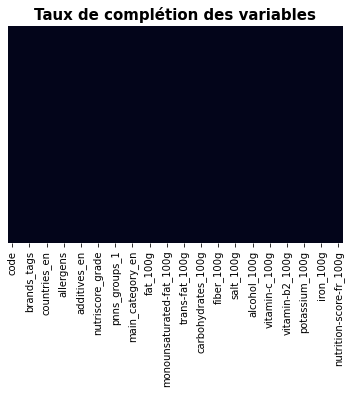

In [14]:
# Visualisation générale des données manquantes
plt.figure(figsize=(6,4))
plt.title('Taux de complétion des variables', fontweight = 'bold', fontsize = 15)
sns.heatmap(data.isna(), yticklabels = False, cbar = False);

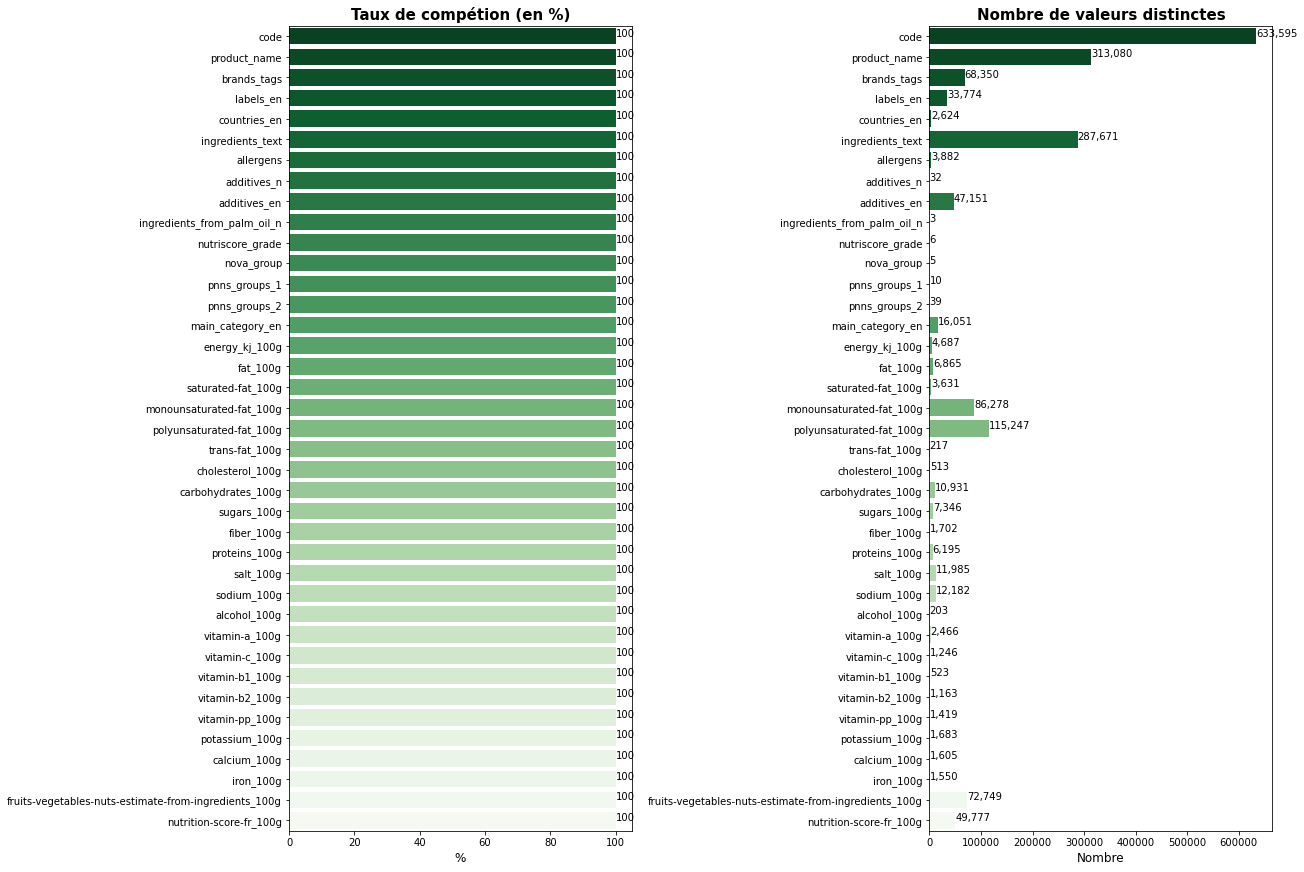

In [15]:
# Initialisation de la grille avec 1 ligne et 2 colonnes
fig = plt.figure(figsize=(18,12), constrained_layout=True)
gs = GridSpec(nrows=1, ncols=2, figure=fig)

# Premier graphique
ax1 = fig.add_subplot(gs[0,0]) # emplacement dans la grille
ax1 = sns.barplot(y = 'Variable name', x = '% Not NaN', data = describe_variables(data), palette='Greens_r')
plt.title('Taux de compétion (en %)', fontweight = 'bold', fontsize = 15)
plt.ylabel("", fontsize = 12)
plt.xlabel("%", fontsize = 12)

for item in ax1.get_xticklabels(): # rotation axe des abscisses
    item.set_rotation(0)
        
for p in ax1.patches:
    etiquette ='{:,.0f}'.format(p.get_width())
    width, height = p.get_width(),p.get_height()
    x = p.get_x() + width + 0.02
    y = p.get_y() + height / 2
    ax1.annotate(etiquette,(x,y))


# Deuxième graphique
ax2 = fig.add_subplot(gs[0,1]) # emplacement dans la grille
ax2 = sns.barplot(y = 'Variable name', x = 'Distinct', data = describe_variables(data), palette='Greens_r')
plt.title('Nombre de valeurs distinctes', fontweight = 'bold', fontsize = 15)
plt.ylabel("", fontsize = 12)
plt.xlabel("Nombre", fontsize = 12)

for item in ax2.get_xticklabels(): # rotation axe des abscisses
    item.set_rotation(0)
    
for p in ax2.patches:
    etiquette ='{:,.0f}'.format(p.get_width())
    width, height = p.get_width(),p.get_height()
    x = p.get_x() + width + 0.02
    y = p.get_y() + height / 2
    ax2.annotate(etiquette,(x,y))

## Analyse univariée <a class="anchor" id="univar"></a>

### Variables quantitatives <a class="anchor" id="quanti"></a>

#### Discrètes

In [16]:
# Fonction qui génère le tableaux des fréquences et fréquences cumulées

def frequences_cumulees(dataframe, col):
    
    effectifs = data[col].value_counts()
    modalites = effectifs.index # l'index de effectifs contient les modalités

    tab = pd.DataFrame(modalites, columns = [col]) # création du tableau à partir des modalités
    tab["n"] = np.round(effectifs.values, 0)
    tab["f"] = np.round(tab["n"] / len(data), 3) # len(data) renvoie la taille de l'échantillon
    tab = tab.sort_values(col) # tri des valeurs de la variable X (croissant)
    tab["F"] = np.round(tab["f"].cumsum(), 3) # cumsum calcule la somme cumulée

    return tab

In [22]:
# Fonction qui génère 3 graphiques: un diagramme en bâtons, un diagramme des effectifs cumulés 
# et un tableau des fréquences

def univariate_plots_discrete(dataframe, col):    
    
    # Initialisation de la grille avec 2 ligne et 2 colonnes
    fig = plt.figure(figsize=(15, 10), constrained_layout=True)
    spec = fig.add_gridspec(ncols=2, nrows=2)
    fig.suptitle(f'{col} distribution', fontsize=20, fontweight ='bold')
    
    # Premier graphique: diagramme en bâtons
    ax0 = fig.add_subplot(spec[0, 0])
    ax0 = dataframe[col].value_counts(normalize=True).plot(kind='bar',width=0.5, color = '#769ac9', ax = ax0)
    plt.title('Diagramme en bâtons', fontsize = 12)# titre du plot   
    
    # Deuxième graphique: diagramme des effectifs cumulés
    ax1 = fig.add_subplot(spec[0, 1])
    ecdf = ECDF(dataframe[col])
    ax1 = plt.plot(ecdf.x,ecdf.y)
    plt.title('Diagramme des effectifs cumulés', fontsize = 12)# titre du plot  
    
    # Troisième graphique: tableau des fréquences
    tab_freq = frequences_cumulees(dataframe, col)
    ax2 = fig.add_subplot(spec[1, :])
    ax2.table(cellText = tab_freq.values, rowLabels = tab_freq.index, colLabels = tab_freq.columns, cellLoc = 'center', 
                    rowLoc = 'center', loc='upper center')
    ax2.axis("off")
    plt.title('Tableau des fréquences', fontsize = 12)# titre du plot  
    
    plt.show()
    
    print("-"*50)
    print(f'Moyenne {col} : {dataframe[col].mean()}')
    print(f'Mode {col} : {dataframe[col].mode()[0]}')
    print("-"*50)
    print()

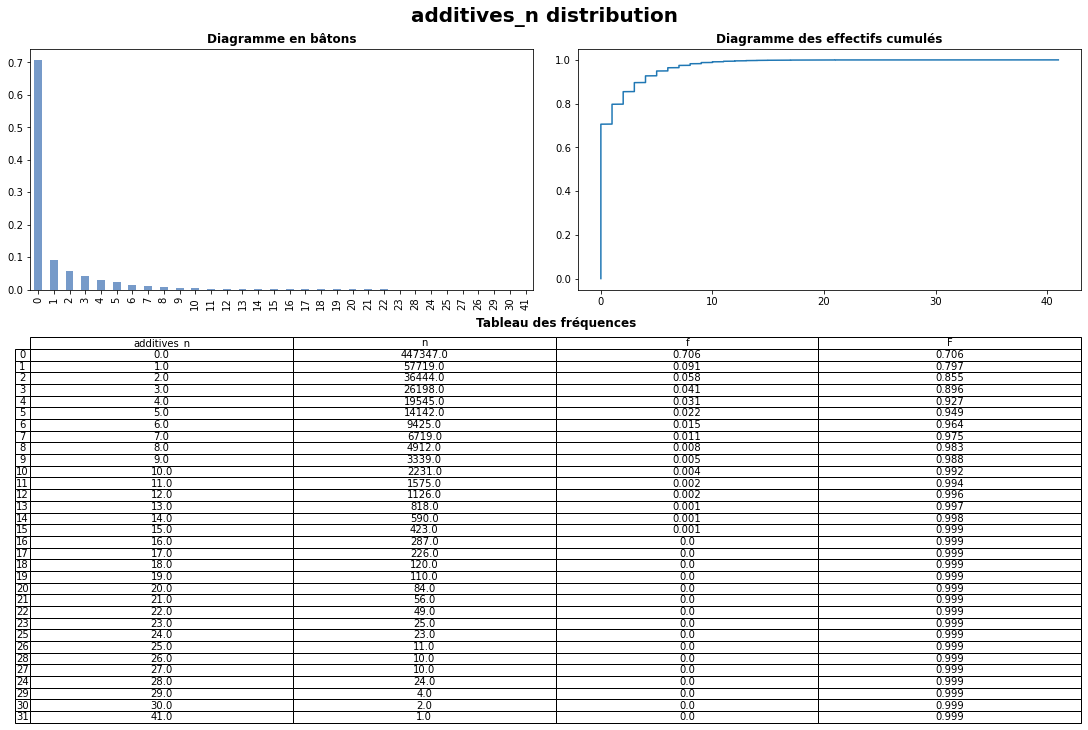

--------------------------------------------------
Moyenne additives_n : 0.9925046756997766
Mode additives_n : 0
--------------------------------------------------



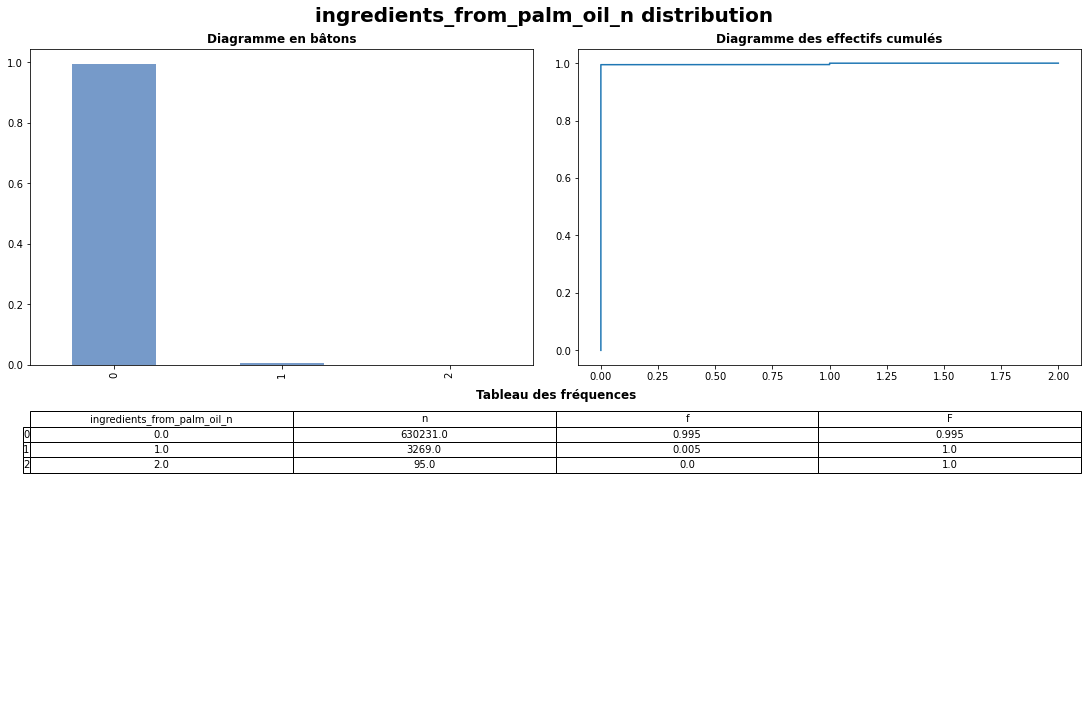

--------------------------------------------------
Moyenne ingredients_from_palm_oil_n : 0.0054593233848120645
Mode ingredients_from_palm_oil_n : 0
--------------------------------------------------



In [23]:
col_quanti_discr = data.select_dtypes(include='int').columns

for c in col_quanti_discr:
    univariate_plots_discrete(data, c)

Les distributions de ces deux variables quantitatives discrètes montrent un pic à 0. Nous remarquons également que la variable additives_n comporte des outliers non repérés dans la partie Cleaning. En effet, l'analyse descriptive permet d'aller plus loin. Nous allons les supprimer ici.

In [24]:
# Produits avec 29 additifs ou plus
produits_additifs_sup29 = data[data['additives_n'] >= 29]['product_name'].unique()
produits_additifs_sup29

array(['star crunch cookies',
       'star crunch cookie with caramel and crisp rice',
       'red velvet creme filled cupcakes, red velvet',
       'creme filled cupcakes',
       'the bakery, apple pie mini cupcakes, cinnamon cream cheese',
       'irtokarkkisekoitus', 'loading…'], dtype=object)

In [25]:
# Dataset hors lignes avec 29 additifs ou plus
data = data[data['additives_n'] < 29]

In [26]:
# Nombre de produits dont le nom est "loading"
len(data[data['product_name'] == 'loading…'])

20

In [27]:
# Suppression des produits dont le nom est "loading"
data = data[data['product_name'] != 'loading…']

#### Continues

##### Mesures de tendance centrale

In [28]:
# Fonction qui permet d'afficher du texte dans chaque histogramme
def draw_text_hist(ax):
    from matplotlib.offsetbox import AnchoredText
    at = AnchoredText(f'Moy = {round(data[c].mean(),2)} \nMed = {round(data[c].median(),2)}, \nSkew = {round(data[c].skew(),2)}',
                      loc=1, prop=dict(size=12), frameon=True)
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

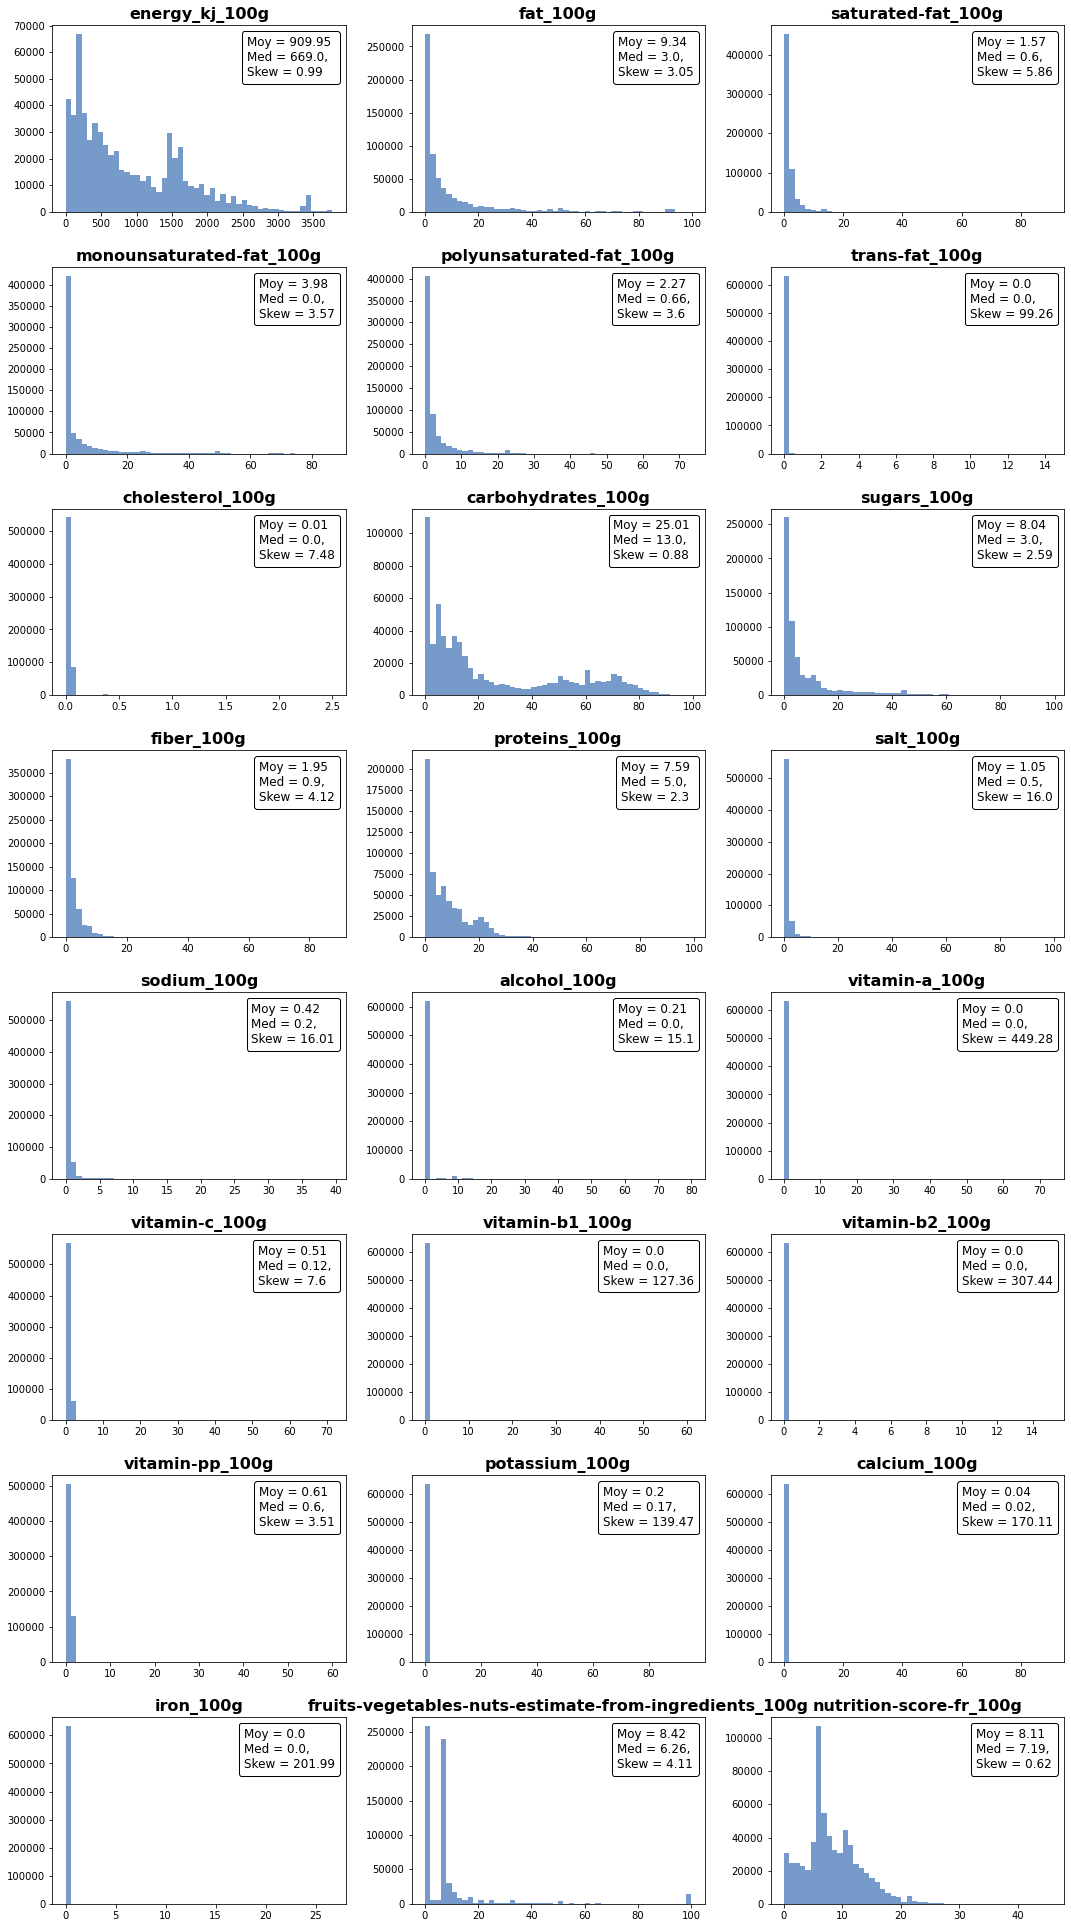

In [29]:
# Affichage de l'histogramme de chaque variable quantitative

col_quanti = data.select_dtypes(include='float').columns
                   

fig = plt.figure(figsize=(15,30))

for i, c in enumerate(col_quanti,1):
    ax = fig.add_subplot(9,3,i)
    ax.hist(data[c], bins = 50, color = '#769ac9')
    ax.set_title(c)
    draw_text_hist(ax)
    ax.title.set_fontweight('bold')
    
plt.tight_layout(w_pad=2, h_pad=2)

- La grande majorité des distributions montre un pic aux alentours de la valeur 0. Il ne s'agit probablement pas de valeurs erronnées car certains produits peuvent ne pas contenir tel ou tel nutriment (exemple de l'huile qui ne contient pas de sucres etc). Cependant, lors de la complétion des valeurs manquantes, il aurait été intéressant d'avoir l'avis d'un nutritionniste afin d'être sûr de les traiter correctement.
- Certaines distributions sont bimodales comme l'énergie ou les fruits/légumes/oléagineux.
- La plupart des distributions ne sont pas symétriques mais étalée vers la droite.
- Les distributions ne semblent pas suivre une distribution Normale

##### Mesures de dispersion

In [30]:
# Fonction qui permet d'afficher du texte dans chaque histogramme
def draw_text_box(ax):
    from matplotlib.offsetbox import AnchoredText
    at = AnchoredText(f'Ecart-type = {round(data[c].std(),2)} \nMin = {round(data[c].min(),2)} \nMax = {round(data[c].max(),2)}',
                      loc=1, prop=dict(size=12), frameon=True)
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

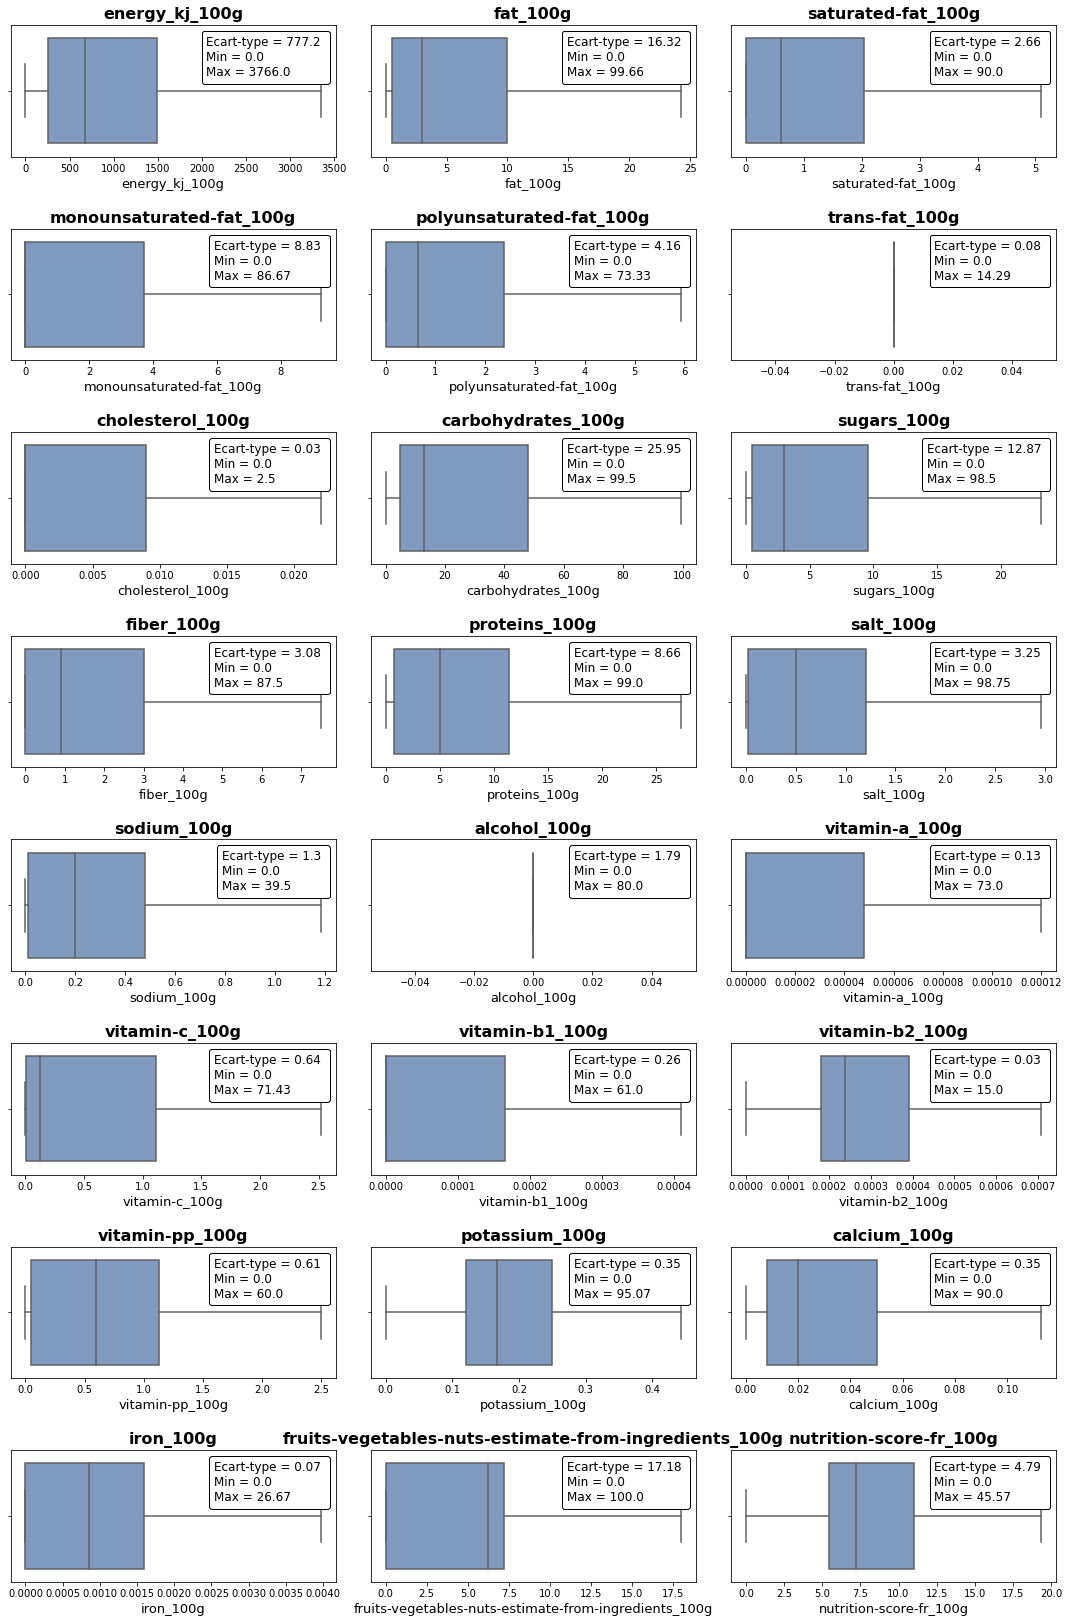

In [31]:
fig = plt.figure(figsize=(15,25))

for i, c in enumerate(col_quanti,1):
    ax = fig.add_subplot(9,3,i)
    ax = sns.boxplot(data = data, x = c, showfliers=False, color = '#769ac9')
    ax.set_title(c)
    draw_text_box(ax)
    ax.title.set_fontweight('bold')
    
plt.tight_layout(w_pad=2, h_pad=2)

##### Test de normalité

Les histogrammes et boites à moustaches nous permettent de penser qu'aucune des variables est normalement distribuée.
Pour vérifier cette hypothèse, nous allons utiliser le test de Shapiro-Wilk.

- Hypothèse nulle H0: la distribution suit une loi Normale
- Hypothèse alternative HA: la distribution ne suit pas une loi Normale
- Si pvalue > 0.05, la pvalue est non significative et l'échantillon suit une loi Normale
- Si pvalue < 0.05, la pvalue est significative et l'échantillon ne suit pas une loi Normale

In [32]:
def test_normalite(data):
    data = data
    # Test de Shapiro-Wilk
    stat, p = shapiro(data)
    p = round(p, 3)
    if p > 0.05:
        result = f'Distribution Normale (pvalue = {p} > 0.05)'
    else:
        result = f'Distribution non Normale (pvalue = {p} < 0.05)'
    
    return result

C:\Users\milie\anaconda3\envs\projet3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


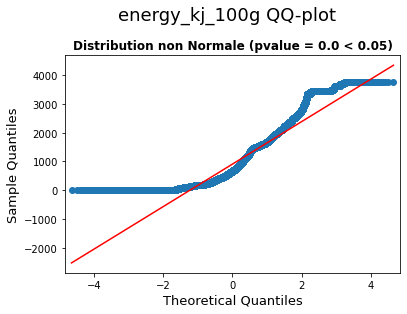

C:\Users\milie\anaconda3\envs\projet3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


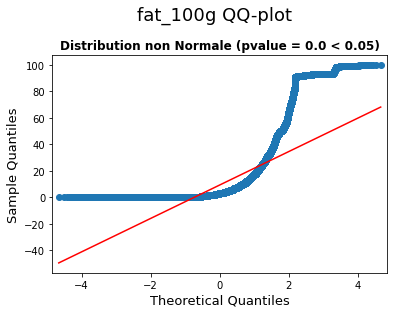

C:\Users\milie\anaconda3\envs\projet3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


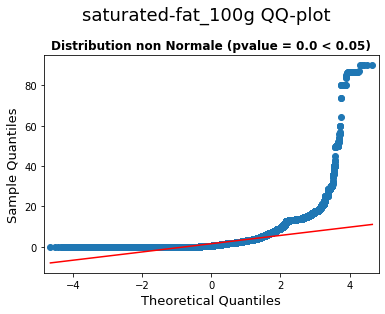

C:\Users\milie\anaconda3\envs\projet3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


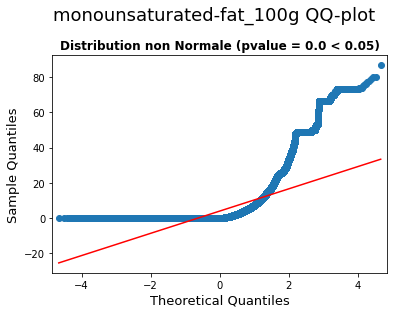

C:\Users\milie\anaconda3\envs\projet3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


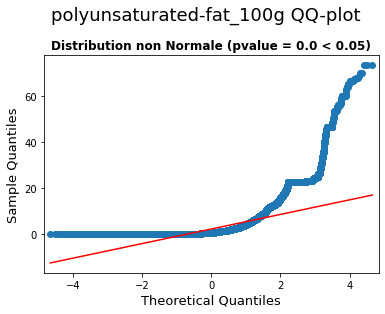

C:\Users\milie\anaconda3\envs\projet3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


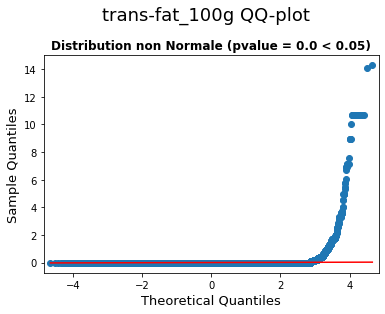

C:\Users\milie\anaconda3\envs\projet3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


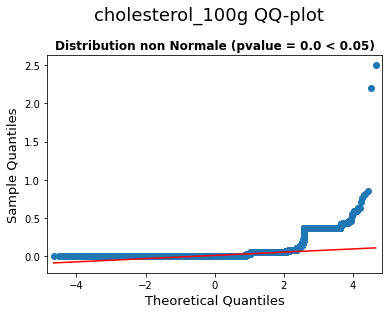

C:\Users\milie\anaconda3\envs\projet3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


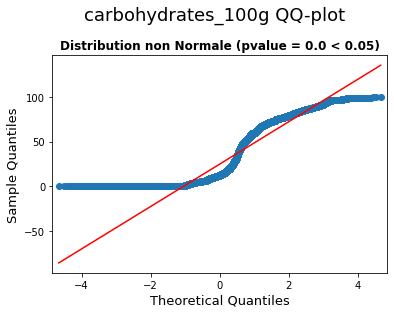

C:\Users\milie\anaconda3\envs\projet3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


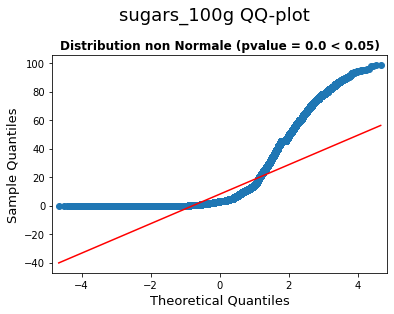

C:\Users\milie\anaconda3\envs\projet3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


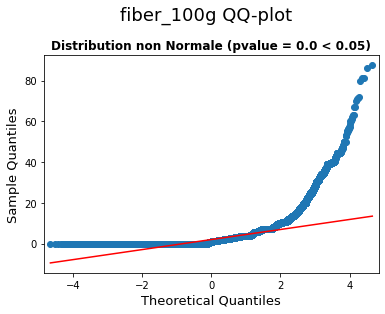

C:\Users\milie\anaconda3\envs\projet3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


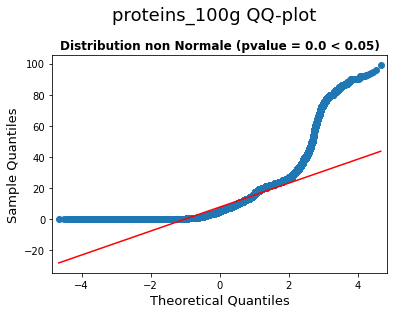

C:\Users\milie\anaconda3\envs\projet3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


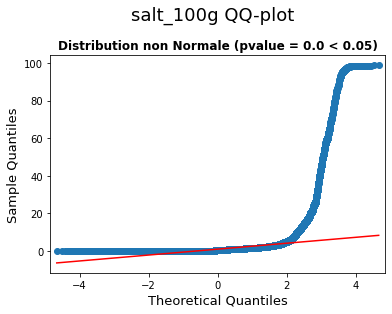

C:\Users\milie\anaconda3\envs\projet3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


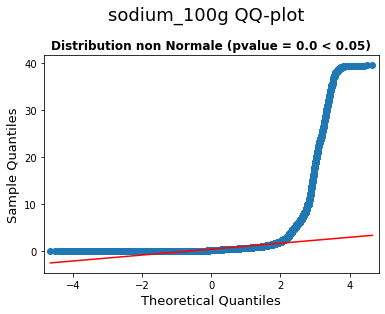

C:\Users\milie\anaconda3\envs\projet3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


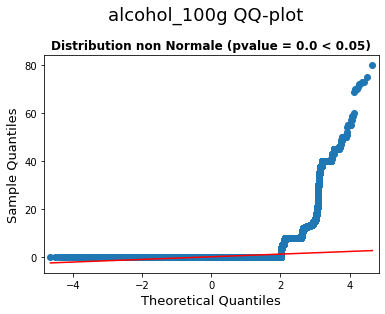

C:\Users\milie\anaconda3\envs\projet3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


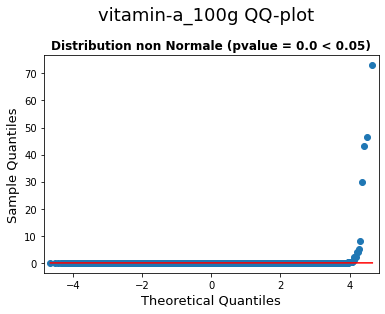

C:\Users\milie\anaconda3\envs\projet3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


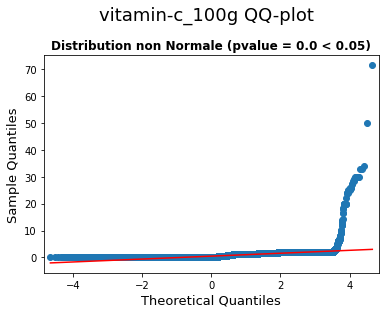

C:\Users\milie\anaconda3\envs\projet3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


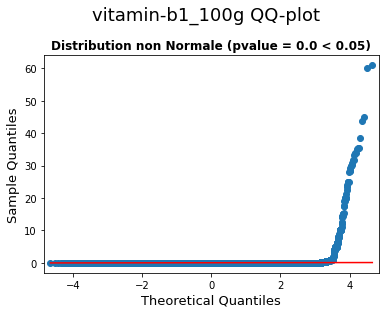

C:\Users\milie\anaconda3\envs\projet3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


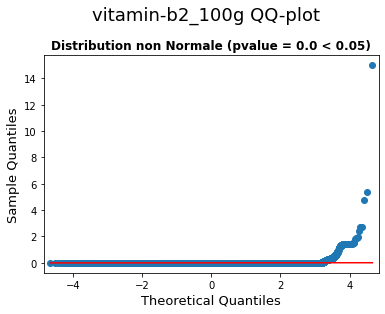

C:\Users\milie\anaconda3\envs\projet3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


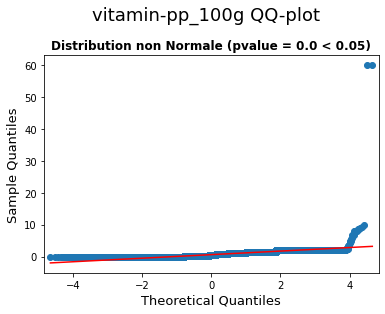

C:\Users\milie\anaconda3\envs\projet3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


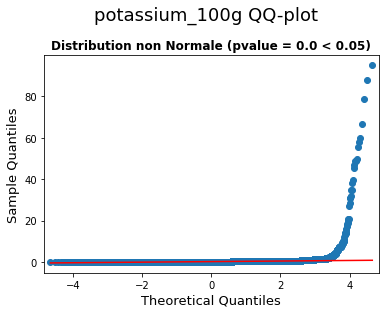

C:\Users\milie\anaconda3\envs\projet3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


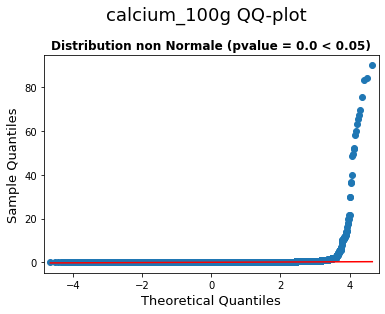

C:\Users\milie\anaconda3\envs\projet3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


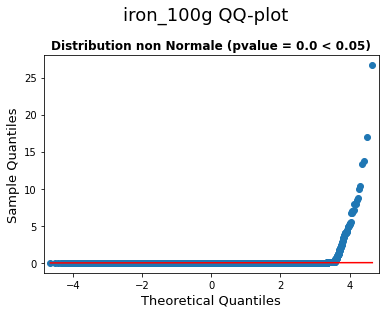

C:\Users\milie\anaconda3\envs\projet3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


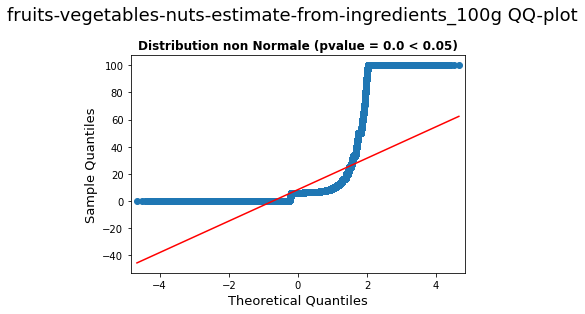

C:\Users\milie\anaconda3\envs\projet3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


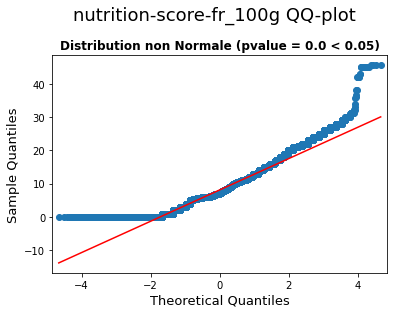

In [33]:
# Affichage des QQ-plots

for c in col_quanti:
    sm.qqplot(data[c], line = "r")
    plt.suptitle(f'{c} QQ-plot', y=1.05, fontsize = 18)
    plt.title(f'{test_normalite(data[c])}', fontsize = 12)
    
    plt.show()

Le test de Normalité de Shapiro-Wilk nous confirme bien qu'aucune distribution n'est Normale.

### Variables qualitatives <a class="anchor" id="quali"></a>

In [34]:
col_quali = data.select_dtypes(include='object').columns.tolist()
col_quali.remove('code')
print(col_quali)

['product_name', 'brands_tags', 'labels_en', 'countries_en', 'ingredients_text', 'allergens', 'additives_en', 'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2', 'main_category_en']


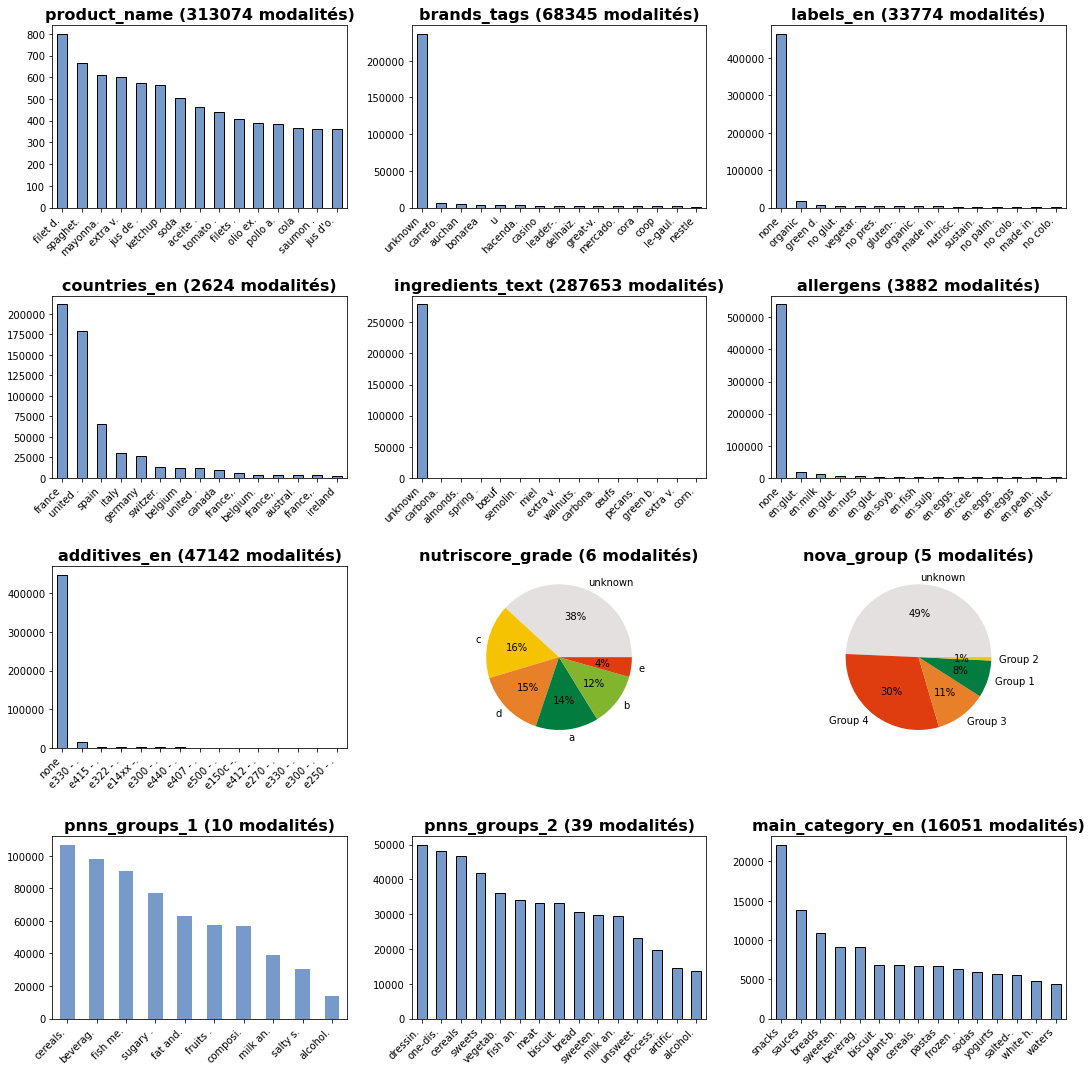

In [35]:
fig = plt.figure(figsize=(15,15))

for i, c in enumerate(col_quali,1):
    ax = fig.add_subplot(4,3,i)
    modalites = data[c].value_counts()
    n_modalites = modalites.shape[0]
    
    if c == 'nutriscore_grade':
        cat_percent = data[c].value_counts(normalize=True) * 100
        values = cat_percent.values
        labels = cat_percent.index
        plt.pie(values, labels = labels, colors = ['#e5e0e0', '#f5c301', '#e78029', '#037d3f', '#81b52e', '#df3c10'], 
                autopct='%.0f%%')
        
    elif c == 'nova_group':
        cat_percent = data[c].value_counts(normalize=True) * 100
        values = cat_percent.values
        labels = cat_percent.index
        plt.pie(values, labels = labels, colors = ['#e5e0e0', '#df3c10', '#e78029', '#037d3f', '#f5c301'], 
                autopct='%.0f%%')
               
    elif n_modalites > 15:
        modalites[0:15].plot.bar(color = '#769ac9',ec='k', ax=ax)
        
    else:
        modalites.plot.bar(color = '#769ac9')
    
    ax.set_title(f'{c} ({n_modalites} modalités)', fontweight='bold')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    short_labels = [l[0:7]+'.' if len(l)>7 else l for l in labels]
    ax.axes.set_xticklabels(short_labels)
    plt.xticks(rotation=45, ha='right')
    
plt.tight_layout(w_pad=2, h_pad=2)

Certaines variables telles que le nom du produit, la marque, les labels etc ont de très nombreuses modalités. Seules les variables pnns_groups_1, pnns_groups_2, nutriscore_grade ou encore le nova_group ont un nombre limité de modalités et pourraient être utilisées lors de l'analyse bivariée.

## Analyse bivariée <a class="anchor" id="bivar"></a>

### Entre deux variables quantitatives <a class="anchor" id="2_quanti"></a>

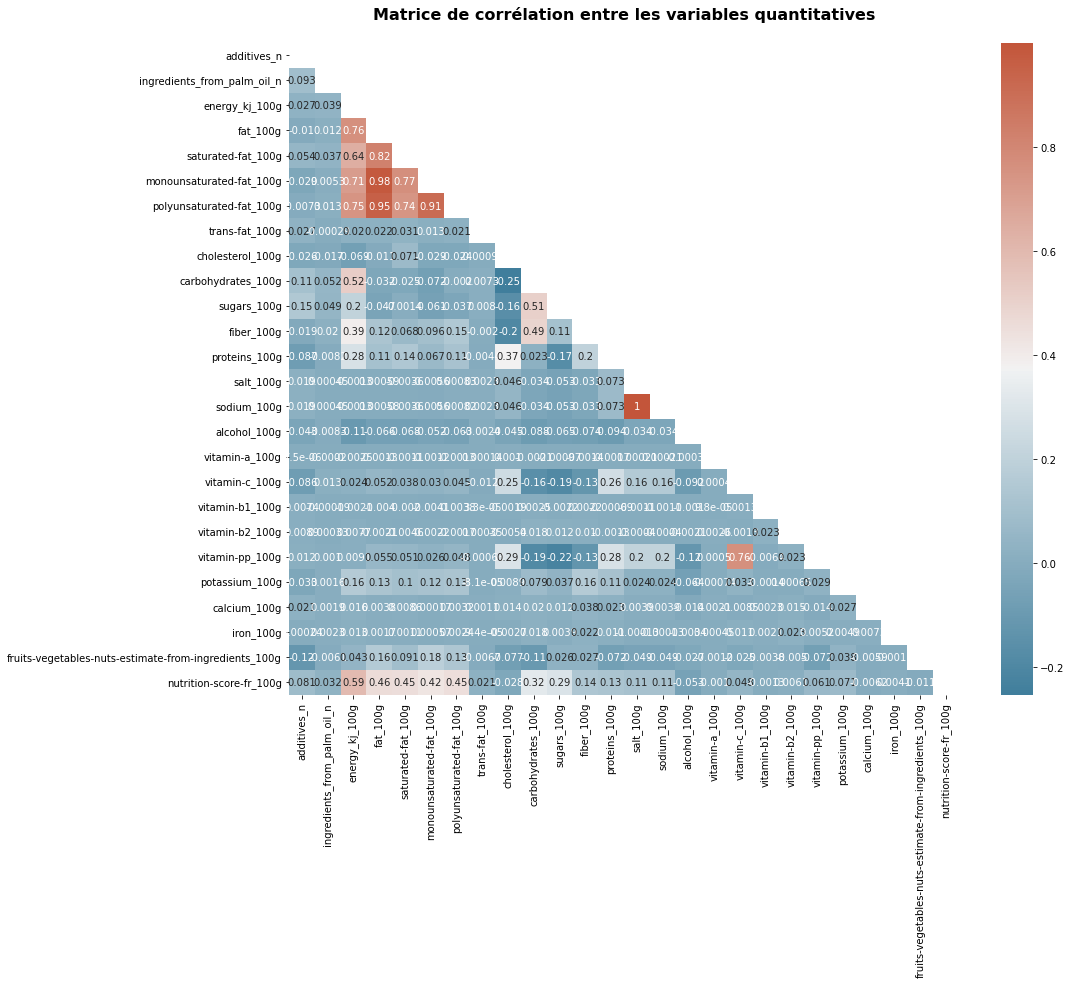

In [37]:
# Corrélation
corr = data.corr()

# Création d'un masque
mask = np.triu(corr)

# Taille du graph
plt.subplots(figsize=(15,12))

# Colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Heatmap avec masque
sns.heatmap(corr, annot = True, mask = mask, cmap=cmap)
plt.title("Matrice de corrélation entre les variables quantitatives\n", fontsize=16);

Comme vu dans la partie cleaning (iterative imputer), les variables les plus corrélées entre elles sont (coeff Pearson > 0.5):

- energy_kj_100g a une forte corrélation avec:
    - fat_100g
    - saturated-fat_100g
    - monounsaturated-fat_100g
    - polyunsaturated-fat_100g
    - carbohydrates_100g
    - nutrition-score-fr_100g
    
- fat_100g a une forte corrélation avec:
    - saturated-fat_100g
    - monounsaturated-fat_100g
    - polyunsaturated-fat_100g
 
- carbohydrates_100g a une forte corrélation avec:
    - sugars_100g

- salt_100g a une forte corrélation avec:
    - sodium_100g

In [38]:
# Fonction permettant d'afficher les nuages de points par groupes de variables

def pairplot(dataframe, col):
    x, y = col
    plt.scatter(dataframe[x], dataframe[y], marker = '.', alpha = 0.3, color = '#769ac9')  
    plt.xlabel(x), plt.ylabel(y)
    plt.text(0.5, 0.9, f'Pearson: {round(dataframe[col].corr().iloc[0,1], 2)}',
        ha = 'center', va = 'center', fontsize=12, c='k', transform = ax.transAxes)

In [41]:
data.rename(columns={'nutrition-score-fr_100g': 'nutriscore'}, inplace = True)

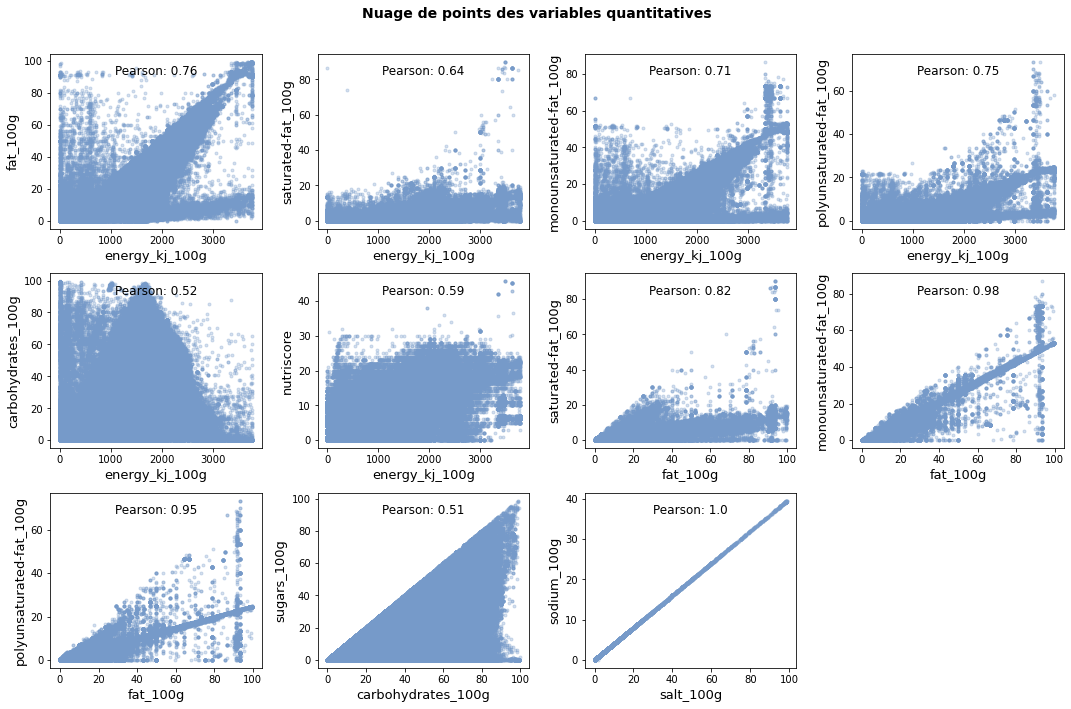

In [42]:
couples_var = {'ener_fat': ['energy_kj_100g', 'fat_100g'],
               'ener_satur_fat': ['energy_kj_100g', 'saturated-fat_100g'],
               'ener_mono_fat': ['energy_kj_100g', 'monounsaturated-fat_100g'],
               'ener_poly_fat': ['energy_kj_100g', 'polyunsaturated-fat_100g'],
               'ener_carb': ['energy_kj_100g', 'carbohydrates_100g'],
               'ener_nutri': ['energy_kj_100g', 'nutriscore'],
               'fat_satur_fat': ['fat_100g', 'saturated-fat_100g'],
               'fat_mono_fat': ['fat_100g', 'monounsaturated-fat_100g'],
               'fat_poly_fat': ['fat_100g', 'polyunsaturated-fat_100g'],
               'carb_sugars': ['carbohydrates_100g', 'sugars_100g'],
               'salt_sodium': ['salt_100g', 'sodium_100g']}

# Affichage des scatterplots par couples de variables

fig = plt.figure(figsize=(15,10))
for i, c in enumerate(couples_var.items(),1):
    ax = fig.add_subplot(3,4,i)
    pairplot(data,c[1])
    #reglin(data, c[0], c[1])
plt.tight_layout(rect=[0,0,1,0.93])
plt.suptitle('Nuage de points des variables quantitatives',
             fontweight='bold', fontsize=14)
plt.show()

Ces nuages de points nous permettent de visualiser les relations linéaires par couple de variables. Nous nous sommes restreint ici aux coefficients de Pearson > 0.5:
- la variable energy_kj_100g est liée linéairement aux aux lipides, glucides et au nutriscore
- la variable fat_100g est fortement liée linéairement aux variables qui rentrent dans sa composition (graisses saturées, monosaturées, polysaturées)
- les glucides sont liés aux sucres
- le sel et sodium ont une corrélation linéaire très importante

### Entre une variable quantitative et une qualitative <a class="anchor" id="quali_quanti"></a>

#### Catégories d'aliments vs principaux nutriments

Nous allons étudier ici la dispersion des principaux nutriments en fonction des pnns_groups_1 et pnns_groups_2.
J'ai choisi ces 2 catégories d'aliments qui ont l'avantage d'avoir un nombre de modalités peu important et qui représentent bien les types d'aliments.

**pnns_groups_1**

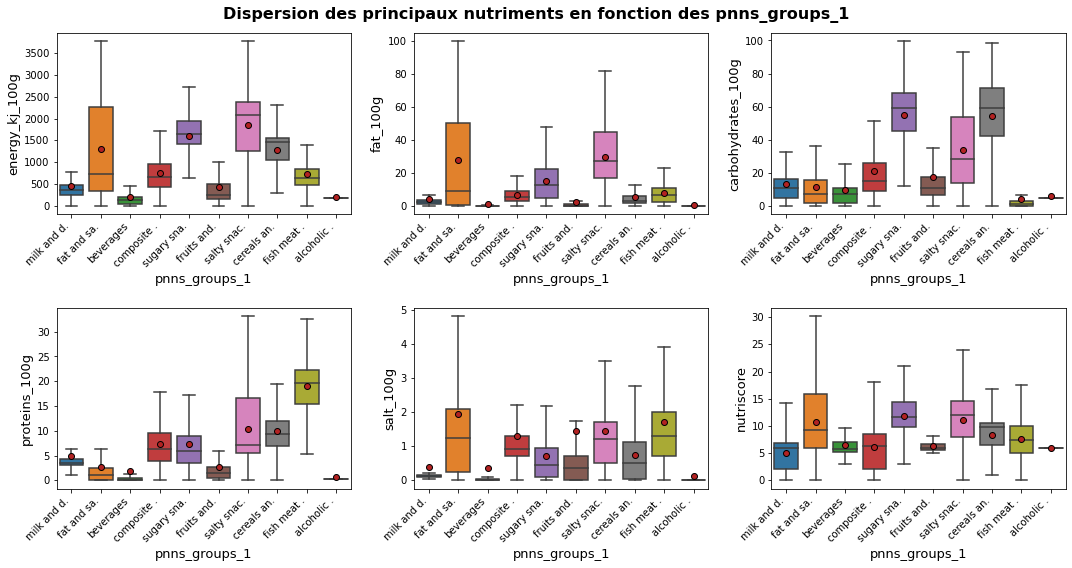

In [43]:
principaux_nutriments = ['energy_kj_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g', 
                         'salt_100g','nutriscore']

fig = plt.figure(figsize=(15,8))

for i, c in enumerate(principaux_nutriments,1):
    ax = fig.add_subplot(2,3,i)
    meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':'firebrick'}
    ax = sns.boxplot(data = data, y = c, x = 'pnns_groups_1', showfliers=False,  showmeans=True, meanprops=meanprops)
    plt.suptitle('Dispersion des principaux nutriments en fonction des pnns_groups_1', fontsize=16,
             fontweight='bold')

    ax.title.set_fontweight('bold')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    short_labels = [l[0:10]+'.' if len(l)>10 else l for l in labels]
    ax.axes.set_xticklabels(short_labels)
    plt.xticks(rotation=45, ha='right')
    
plt.tight_layout(w_pad=2, h_pad=2)

On voit ici que les valeurs des principaux nutriments sont très différentes d'un pnns_groups_1 à un autre. Par exemple, les lipides pour 100g sont plus dispersés et importants pour la catégorie "fat and sauce" alors qu'ils sont faibles et peu dispersés pour les pnns_groups_1 lait et produits laitiers, boissons, fruits et légumes, ou boissons alcolisées.

Pour savoir si l'on peut prédire correctement les valeurs des principaux nutriments par le pnns_groups_1, notre modèle doit parvenir à expliquer un gros pourcentage des variations des données. Si c'est le cas, cela signifie que les variables pnns_groups_1 et principaux nutriments sont fortement corrélées.

Le test applicable est l'ANOVA à un facteur de comparaison de plus de deux positions. Les conditions d'utilisation de ce test sont:
- les valeurs de chaque échantillon doivent être normalement distribuées
- les variances doivent être égales
Les hypothèses sont:
- H0: μ1 = μ2 = ... = μk
- HA : ] (i,j) tel que μi = μj
- alpha = 0.05

Cependant, comme nous savons que nos données ne sont pas normalement distribuées, nous utiliserons le test non paramétrique de Kruskall-Wallis qui est un test sur la moyenne des rangs. Nous calculerons quand même l'ANOVA mais uniquement à titre informatif.

In [44]:
def Anova_test(data, liste_var_quanti, var_quali):
    print('Test paramétrique ANOVA: ')
    print()
    for nutri in liste_var_quanti:
        Y = nutri
        X = var_quali
        YvsX = f"{Y} ~ {X}"
        mod = ols(YvsX, data = data).fit()
        aov_table = sm.stats.anova_lm(mod, typ=2)
        print(f'Variable {nutri} par {var_quali}')
        if aov_table['PR(>F)'][0] <= 0.05:
            print(f"pvaleur: {aov_table['PR(>F)'][0]} < 0.05 => on rejette H0, les moyennes entre les {X} sont différentes")
        else:
            print(f"pvaleur: {aov_table['PR(>F)'][0]} > 0.05 => on accepte H0, les moyennes entre les {X} sont identiques")
        print('-----------------------------------------------------------------------------------')

In [45]:
principaux_nutriments = ['energy_kj_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g', 
                         'salt_100g','nutriscore']

Anova_test(data, principaux_nutriments, 'pnns_groups_1')

Test paramétrique ANOVA: 

Variable energy_kj_100g par pnns_groups_1
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes entre les pnns_groups_1 sont différentes
-----------------------------------------------------------------------------------
Variable fat_100g par pnns_groups_1
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes entre les pnns_groups_1 sont différentes
-----------------------------------------------------------------------------------
Variable carbohydrates_100g par pnns_groups_1
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes entre les pnns_groups_1 sont différentes
-----------------------------------------------------------------------------------
Variable proteins_100g par pnns_groups_1
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes entre les pnns_groups_1 sont différentes
-----------------------------------------------------------------------------------
Variable salt_100g par pnns_groups_1
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes entre les pnns_g

In [46]:
def Kruskal_Wallis_test(data, liste_var_quanti, var_quali):
    print('Test non paramétrique de Kruskal Wallis: ')
    print()
    for nutri in liste_var_quanti:
        kstat, pval = kruskal(*[group[nutri].values for name, group in data.groupby(var_quali)])
        print(f'Variable {nutri} par {var_quali}')
        if pval <= 0.05:
            print(f"pvaleur: {pval} < 0.05 => on rejette H0, les moyennes entre les {var_quali} sont différentes")
        else:
            print(f"pvaleur: {pval} > 0.05 => on accepte H0, les moyennes entre les {var_quali} sont identiques")
        print('-----------------------------------------------------------------------------------')

In [47]:
Kruskal_Wallis_test(data, principaux_nutriments, 'pnns_groups_1')

Test non paramétrique de Kruskal Wallis: 

Variable energy_kj_100g par pnns_groups_1
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes entre les pnns_groups_1 sont différentes
-----------------------------------------------------------------------------------
Variable fat_100g par pnns_groups_1
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes entre les pnns_groups_1 sont différentes
-----------------------------------------------------------------------------------
Variable carbohydrates_100g par pnns_groups_1
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes entre les pnns_groups_1 sont différentes
-----------------------------------------------------------------------------------
Variable proteins_100g par pnns_groups_1
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes entre les pnns_groups_1 sont différentes
-----------------------------------------------------------------------------------
Variable salt_100g par pnns_groups_1
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes 

Les tests ANOVA et de Kruskal Wallis confirment l'hypothèse que la moyenne de chaque nutriment diffère selon les pnns_groups_1.

**pnns_groups_2**

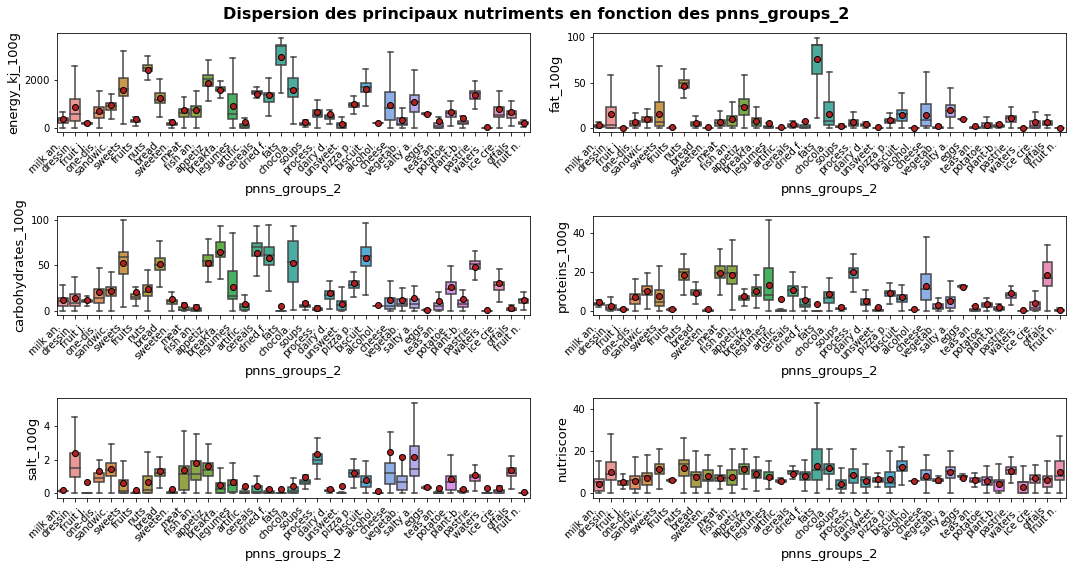

In [48]:
principaux_nutriments = ['energy_kj_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g', 
                         'salt_100g','nutriscore']

fig = plt.figure(figsize=(15,8))

for i, c in enumerate(principaux_nutriments,1):
    ax = fig.add_subplot(3,2,i)
    meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':'firebrick'}
    ax = sns.boxplot(data = data, y = c, x = 'pnns_groups_2', showfliers=False,  showmeans=True, meanprops=meanprops)
    plt.suptitle('Dispersion des principaux nutriments en fonction des pnns_groups_2', fontsize=16,
             fontweight='bold')

    ax.title.set_fontweight('bold')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    short_labels = [l[0:7]+'.' if len(l)>7 else l for l in labels]
    ax.axes.set_xticklabels(short_labels)
    plt.xticks(rotation=45, ha='right')
    
plt.tight_layout(w_pad=2, h_pad=2)

In [49]:
Anova_test(data, principaux_nutriments, 'pnns_groups_2')

Test paramétrique ANOVA: 

Variable energy_kj_100g par pnns_groups_2
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes entre les pnns_groups_2 sont différentes
-----------------------------------------------------------------------------------
Variable fat_100g par pnns_groups_2
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes entre les pnns_groups_2 sont différentes
-----------------------------------------------------------------------------------
Variable carbohydrates_100g par pnns_groups_2
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes entre les pnns_groups_2 sont différentes
-----------------------------------------------------------------------------------
Variable proteins_100g par pnns_groups_2
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes entre les pnns_groups_2 sont différentes
-----------------------------------------------------------------------------------
Variable salt_100g par pnns_groups_2
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes entre les pnns_g

In [50]:
Kruskal_Wallis_test(data, principaux_nutriments, 'pnns_groups_2')

Test non paramétrique de Kruskal Wallis: 

Variable energy_kj_100g par pnns_groups_2
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes entre les pnns_groups_2 sont différentes
-----------------------------------------------------------------------------------
Variable fat_100g par pnns_groups_2
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes entre les pnns_groups_2 sont différentes
-----------------------------------------------------------------------------------
Variable carbohydrates_100g par pnns_groups_2
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes entre les pnns_groups_2 sont différentes
-----------------------------------------------------------------------------------
Variable proteins_100g par pnns_groups_2
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes entre les pnns_groups_2 sont différentes
-----------------------------------------------------------------------------------
Variable salt_100g par pnns_groups_2
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes 

Les tests ANOVA et de Kruskal Wallis confirment ici aussi l'hypothèse selon laquelle la moyenne de chaque nutriment diffère selon les pnns_groups_2.

#### Nutrigrade vs principaux nutriments

On espère que notre modèle parvienne à expliquer un gros pourcentage des variations des données. Si c'est le cas, cela signifie que les variables nutrigrade et les principaux nutriments sont fortement corrélées

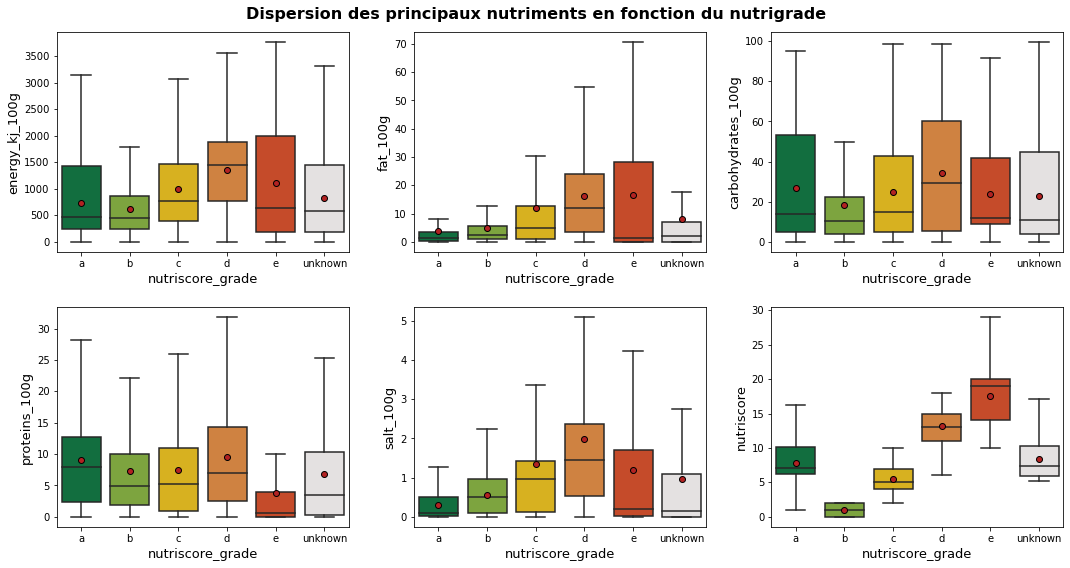

In [51]:
principaux_nutriments = ['energy_kj_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g', 
                         'salt_100g','nutriscore']

my_colors = ['#037d3f', '#81b52e', '#f5c301', '#e78029',   '#df3c10', '#e5e0e0']
sns.set_palette(my_colors) 

fig = plt.figure(figsize=(15,8))

for i, c in enumerate(principaux_nutriments,1):
    ax = fig.add_subplot(2,3,i)
    meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':'firebrick'}
    ax = sns.boxplot(data = data, y = c, x = 'nutriscore_grade', order = ['a', 'b', 'c', 'd', 'e', 'unknown'],
                     showfliers=False,  showmeans=True, meanprops=meanprops)
    plt.suptitle('Dispersion des principaux nutriments en fonction du nutrigrade', fontsize=16,
             fontweight='bold')

    ax.title.set_fontweight('bold')
    
plt.tight_layout(w_pad=2, h_pad=2)

La dispersion des principaux nutriments par nutriscore_grade ne semble pas totalement cohérente. En effet, pour la variable fat_100g par exemple et les grades A, B, C et D, la médiane et moyenne semblent augmenter en fonction du grade. Hors, pour le grade E, on observe une médiane très faible indiquant un taux de lipides peu important alors que l'on sait qu'il influe sur le grade. Dans le doute, la variable nutriscore_grade ne sera pas utilisée dans l'application.

Le fait de compléter de très nombreuses valeurs manquantes par différentes méthodes sans vérification par un expert nous laisse penser que ce traitement n'était peut être pas le bon et a rajouté du bruit dans le dataset.

In [52]:
Anova_test(data, principaux_nutriments, 'nutriscore_grade')

Test paramétrique ANOVA: 

Variable energy_kj_100g par nutriscore_grade
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes entre les nutriscore_grade sont différentes
-----------------------------------------------------------------------------------
Variable fat_100g par nutriscore_grade
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes entre les nutriscore_grade sont différentes
-----------------------------------------------------------------------------------
Variable carbohydrates_100g par nutriscore_grade
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes entre les nutriscore_grade sont différentes
-----------------------------------------------------------------------------------
Variable proteins_100g par nutriscore_grade
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes entre les nutriscore_grade sont différentes
-----------------------------------------------------------------------------------
Variable salt_100g par nutriscore_grade
pvaleur: 0.0 < 0.05 => on rejette H0, le

In [53]:
Kruskal_Wallis_test(data, principaux_nutriments, 'nutriscore_grade')

Test non paramétrique de Kruskal Wallis: 

Variable energy_kj_100g par nutriscore_grade
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes entre les nutriscore_grade sont différentes
-----------------------------------------------------------------------------------
Variable fat_100g par nutriscore_grade
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes entre les nutriscore_grade sont différentes
-----------------------------------------------------------------------------------
Variable carbohydrates_100g par nutriscore_grade
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes entre les nutriscore_grade sont différentes
-----------------------------------------------------------------------------------
Variable proteins_100g par nutriscore_grade
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes entre les nutriscore_grade sont différentes
-----------------------------------------------------------------------------------
Variable salt_100g par nutriscore_grade
pvaleur: 0.0 < 0.05 => o

Les tests ANOVA et de Kruskal Wallis confirment ici aussi l'hypothèse selon laquelle la moyenne de chaque nutriment diffère selon la lettre du nutriscore.

#### TOP 5 Pays vs nutriscore

In [54]:
TOP5_countries = data['countries_en'].value_counts()[0:5].index
data_TOP5_countries = data[data['countries_en'].isin(TOP5_countries)]

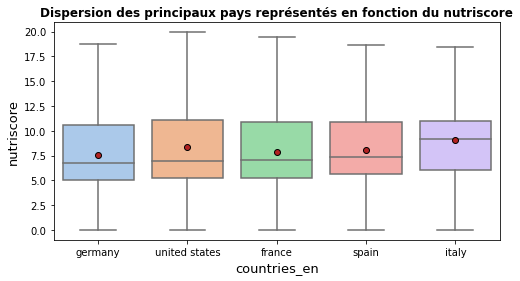

In [55]:
ordre_countries = data_TOP5_countries.groupby(['countries_en'])['nutriscore'].median().sort_values().index

plt.figure(figsize=(8,4))
sns.set_palette('pastel')
plt.title('Dispersion des principaux pays représentés en fonction du nutriscore', fontsize=12,
             fontweight='bold')
meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':'firebrick'}
sns.boxplot(x = 'countries_en', y = 'nutriscore', showfliers=False, order = ordre_countries, 
            data = data_TOP5_countries, showmeans=True, meanprops=meanprops);

La dispersion du nutriscore en fonction des 5 pays les plus représentés est assez similaire avec une médiane plus importante pour l'Italie laissant penser que les aliments du dataset sont plus mal notés.

In [56]:
Kruskal_Wallis_test(data_TOP5_countries, ['nutriscore'], 'countries_en')

Test non paramétrique de Kruskal Wallis: 

Variable nutriscore par countries_en
pvaleur: 0.0 < 0.05 => on rejette H0, les moyennes entre les countries_en sont différentes
-----------------------------------------------------------------------------------


Le test non paramétrique de Kruskal_Wallis nous confirme que les moyennes du nutriscore par pays sont différentes.

### Entre deux variables qualitatives <a class="anchor" id="quali_quali"></a>

#### Catégories d'aliments vs nutriscore_grade

Le test applicable est le test du Chi2. Les conditions d'utilisation de ce test sont:
- chaque effectif du tableau doit être supérieur ou égal à 5

Les hypothèses sont:
- H0: indépendance entre les 2 variables qualitatives
- HA: association entre les 2 variables qualitatives
- alpha = 0.05

<div class="alert alert-block alert-info">
    <p> Que faire si la condition des effectifs > 5 non respectée? test de fisher?</p>
    <p> Ne fonctionne que sur 2x2 table</p>
</div>

##### pnns_groups_1

In [ ]:
#conda install -c conda-forge pingouin

#### import pingouin as pg

In [63]:
expected, observed, stat = pg.chi2_independence(data, 'pnns_groups_1' , 'nutriscore_grade')

In [64]:
# si pavaleur pearson < 0.05 associées
stat

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,220943.502398,45.0,0.0,0.264094,1.0
1,cressie-read,0.666667,212589.155694,45.0,0.0,0.259053,1.0
2,log-likelihood,0.000000,210719.430358,45.0,0.0,0.257911,1.0
3,freeman-tukey,-0.500000,226443.762819,45.0,0.0,0.267361,1.0
4,mod-log-likelihood,-1.000000,270822.792083,45.0,0.0,0.292389,1.0
5,neyman,-2.000000,788797.240996,45.0,0.0,0.499001,1.0


In [ ]:
# Ne marche que pour des tables 2*2
#tab_cont = pd.crosstab(data['pnns_groups_1'], data['nutriscore_grade'])
#oddsr, p = fisher_exact(tab_cont)
#p

In [65]:
def chi2_test(data, var_quali_1, var_quali_2, palette = sns.color_palette('pastel')):
    #my_colors = ['#037d3f', '#81b52e', '#f5c301', '#e78029',   '#df3c10', '#e5e0e0']
    #sns.set_palette(my_colors)
    palette = palette
    # Table de contingence
    tab_cont = pd.crosstab(data[var_quali_1], data[var_quali_2])
    plt.figure(figsize=(12, 10))
    plt.title(f'Table de contingence {var_quali_1} / {var_quali_2}', fontsize=12, fontweight='bold')
    sns.heatmap(tab_cont, cmap="YlGnBu", annot=True, cbar=False, fmt="d")
    plt.xticks(rotation=45, ha='right')
    plt.show()
    # Diagramme en barres selon les profils colonnes
    tab_cont_prop = pd.crosstab(data[var_quali_1], data[var_quali_2], normalize="index")
    modalites = len(tab_cont.columns)
    if modalites <= 5:
        with sns.color_palette(palette):
            tab_cont_prop.plot(kind='bar', stacked=True, figsize=(15, 9), width = 0.8)
            plt.legend(loc="upper left", ncol=6)
            plt.xlabel(var_quali_1)
            plt.ylabel("Proportion")
            plt.xticks(rotation=45, ha='right')
            plt.title('Diagramme en barres selon les profils colonnes', fontsize=12, fontweight='bold')
        # Affichage des pourcentages
        #for n, x in enumerate([*tab_cont.index.values]):
         #   for (proportion, y_loc) in zip(tab_cont_prop.loc[x], tab_cont_prop.loc[x].cumsum()):
          #      plt.text(x = n - 0.17, y = (y_loc - proportion) + (proportion / 2), s=f'{np.round(proportion * 100, 0)}%', 
           #              color="black", fontsize=8)
            plt.show()
        
        if len(np.where(tab_cont <= 5)[0]) == 0:
            print('Chaque effectif de la table de contingence >= 5 => Test du Chi2 applicable')
            # Running Chi2 test
            print('-------------------------------------------------------------------')
            st_chi2, st_p, st_dof, st_exp = chi2_contingency(tab_cont) 
            print(f"Chi2: {st_chi2}")
            print(f"Degrees of freedom: {st_dof}")    
            print('-------------------------------------------------------------------')
            if st_p < 0.05:
                print(f"pvalue: {st_p} < 0.05 => on rejette H0, les variables sont dépendantes")
            else:
                print(f"pvalue: {st_p} > 0.05 => on accepte H0, les variables sont indépendantes")
        else:
            print('Au moins un effectif de la table de contingence < 5 => Test du Chi2  non applicable')
    else:
        if len(np.where(tab_cont <= 5)[0]) == 0:
            print('Chaque effectif de la table de contingence >= 5 => Test du Chi2 applicable')
            # Running Chi2 test
            print('-------------------------------------------------------------------')
            st_chi2, st_p, st_dof, st_exp = chi2_contingency(tab_cont) 
            print(f"Chi2: {st_chi2}")
            print(f"Degrees of freedom: {st_dof}")    
            print('-------------------------------------------------------------------')
            if st_p < 0.05:
                print(f"pvalue: {st_p} < 0.05 => on rejette H0, les variables sont dépendantes")
            else:
                print(f"pvalue: {st_p} > 0.05 => on accepte H0, les variables sont indépendantes")
        else:
            print('Au moins un effectif de la table de contingence < 5 => Test du Chi2  non applicable')

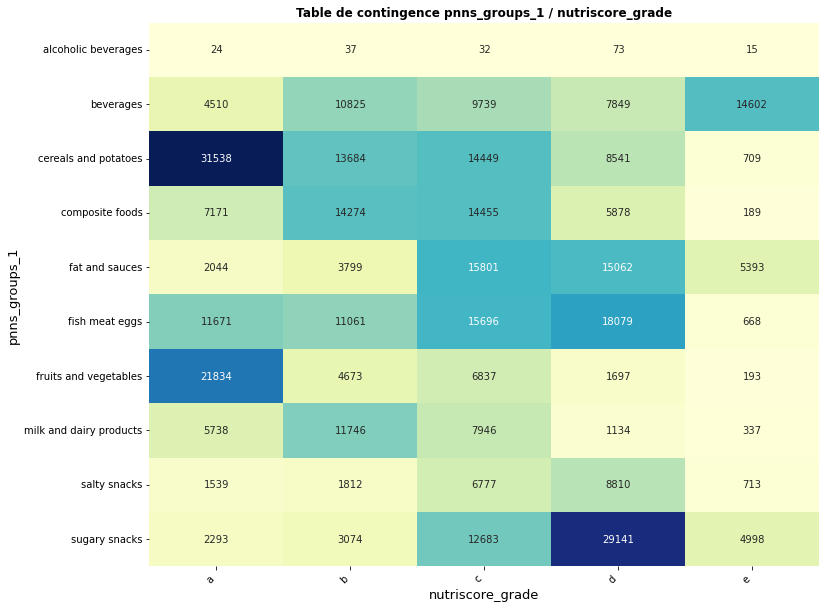

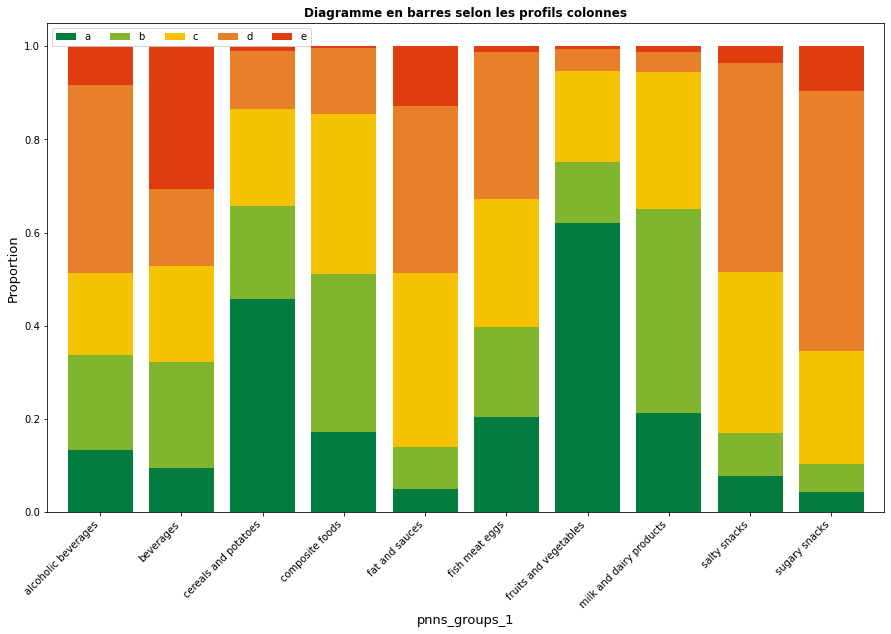

Chaque effectif de la table de contingence >= 5 => Test du Chi2 applicable
-------------------------------------------------------------------
Chi2: 185803.8154783786
Degrees of freedom: 36
-------------------------------------------------------------------
pvalue: 0.0 < 0.05 => on rejette H0, les variables sont dépendantes


In [66]:
data_nutri = data[data['nutriscore_grade'] != 'unknown']
my_colors = ['#037d3f', '#81b52e', '#f5c301', '#e78029',   '#df3c10', '#e5e0e0']
chi2_test(data_nutri, 'pnns_groups_1', 'nutriscore_grade', palette = my_colors)

Les nutriscore_grades 'unknown' représentent une forte proportion de chaque pnns_groups_1. En effet le KNN n'ayant pu être appliqué par manque de puissance, les valeurs manquantes ont été remplacées par cette modalité. Nous avons supprimé cette modalité pour une meilleure visibilité de la proportion des nutriscores dans les catégories d'aliments.

Le test du Chi2 confirme l'hypothèse d'association entre les variables pnns_groups_1 et nutriscore_grades.

Les meilleures notes semblent être attribuées aux fruits et légumes et céréales / pommes de terre alors que les moins bonnes sont données aux boissons, gras et sauces et snacks sucrés.

##### pnns_groups_2

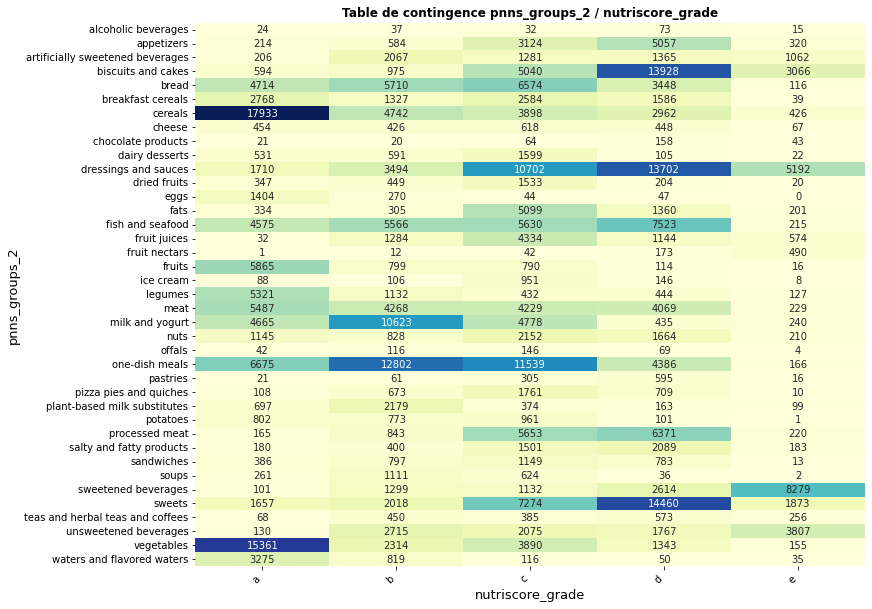

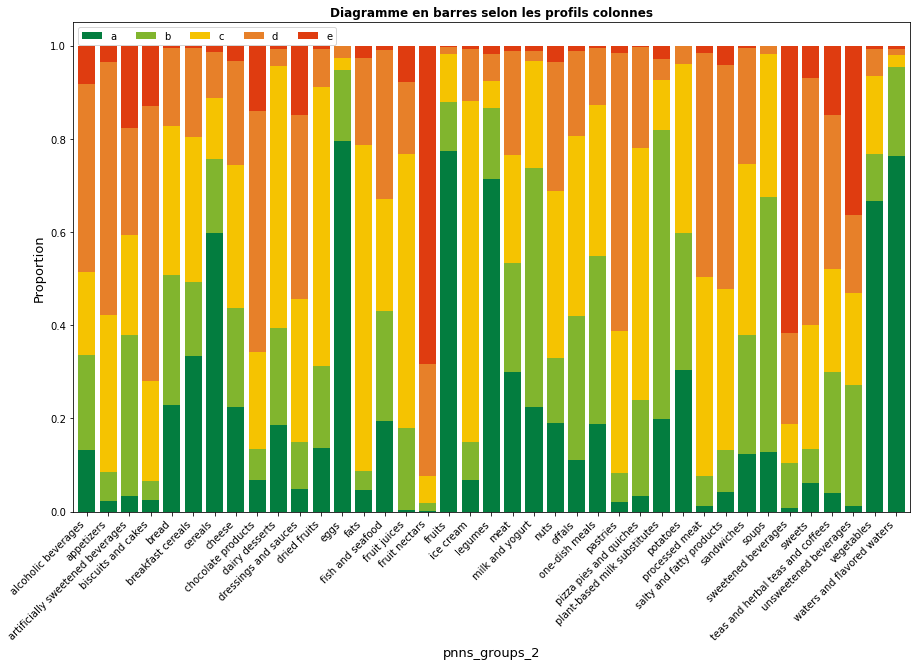

Au moins un effectif de la table de contingence < 5 => Test du Chi2  non applicable


In [73]:
chi2_test(data_nutri, 'pnns_groups_2', 'nutriscore_grade', palette = my_colors)

Le test du Chi2 n'a pu être appliqué car certains types d'aliments ne sont pas ou peu représentés dans certains nutriscores (exemple: oeufs non présents dans la catégorie E).

Les meilleures notes semblent être attribuées aux eaux, fruits et légumes oeufs et céréales alors que les moins bonnes sont données aux boissons sucrées, nectars de fruits, biscuits et gâteaux.

#### Catégories d'aliments vs nova_group

##### pnns_groups_1

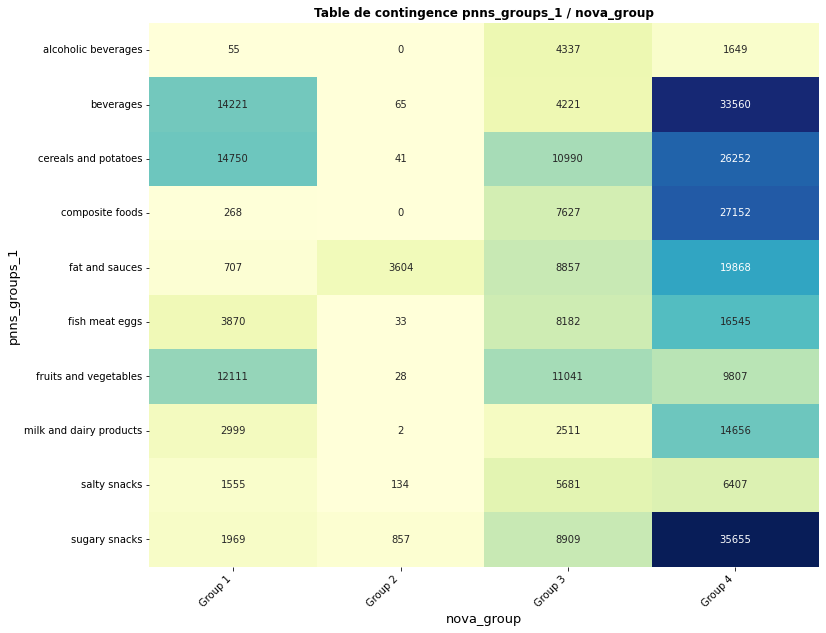

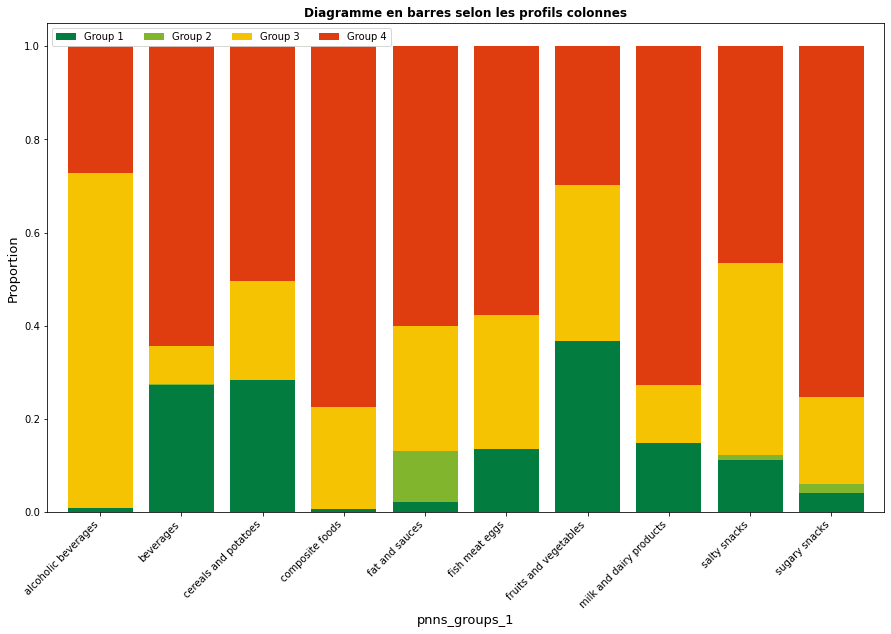

Au moins un effectif de la table de contingence < 5 => Test du Chi2  non applicable


In [74]:
data_nova = data[data['nova_group'] != 'unknown']
my_colors = ['#037d3f', '#81b52e', '#f5c301', '#df3c10', '#e5e0e0']
chi2_test(data_nova, 'pnns_groups_1', 'nova_group', palette = my_colors)

Le test du Chi2 n'a pu être appliqué car certains types d'aliments ne sont pas ou peu représentés dans certains groupes nova (exemple: pas de boissons alcolisées dans le groupe 2).

Les produits les moins transformés se trouvent dans les fruits, céréales et boissons alors que les plus transformés sont en grande proportion dans tous les types d'aliments dont notamment les aliments composites, les snacks sucrés et le lait et produits laitiers.

##### pnns_groups_2

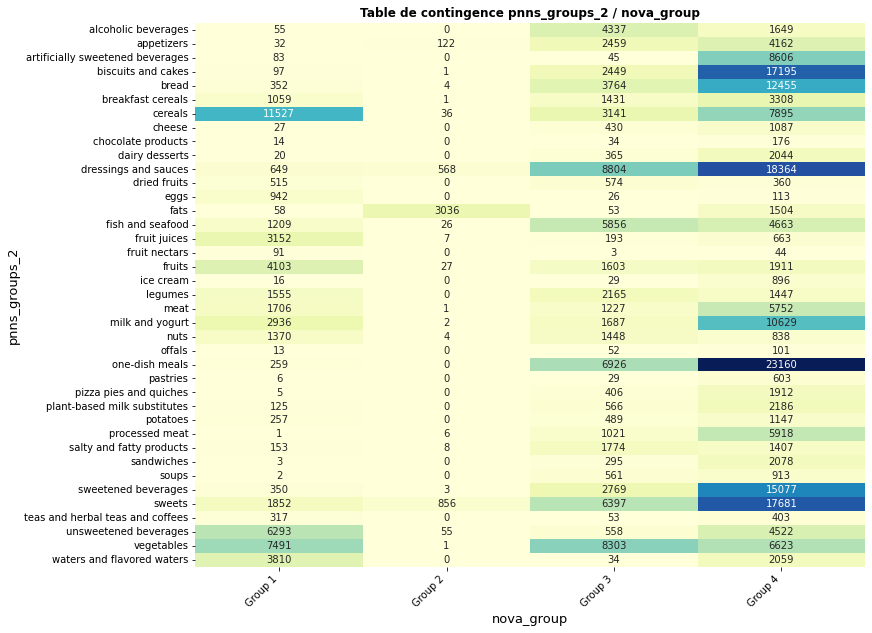

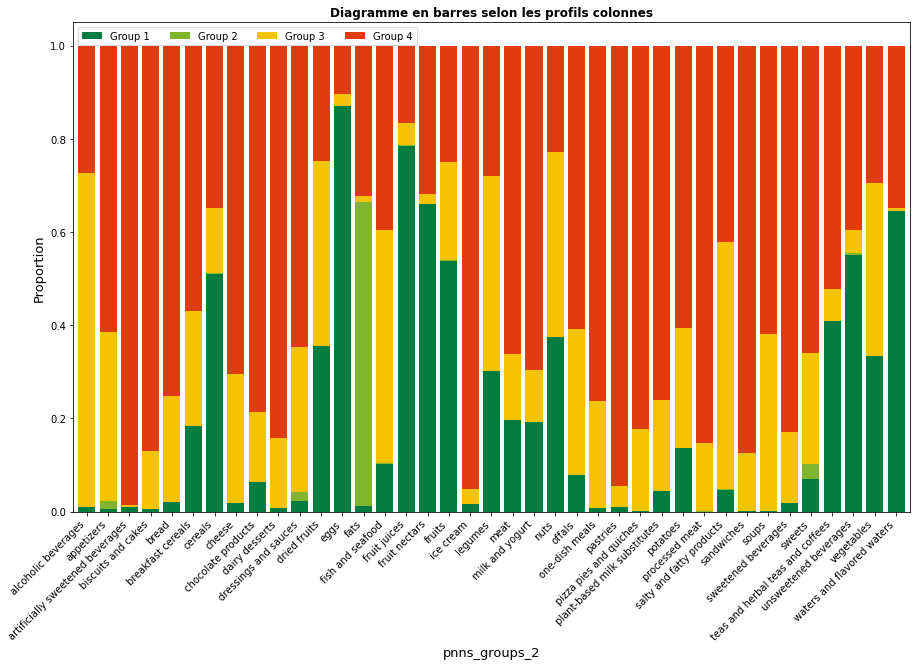

Au moins un effectif de la table de contingence < 5 => Test du Chi2  non applicable


In [75]:
my_colors = ['#037d3f', '#81b52e', '#f5c301', '#df3c10', '#e5e0e0']
chi2_test(data_nova, 'pnns_groups_2', 'nova_group', palette = my_colors)

Le test du Chi2 n'a pu être appliqué car certains types d'aliments ne sont pas ou peu représentés dans certains groupes nova (exemple: pas de boissons alcolisées dans le groupe 2).

Les produits les moins transformés se trouvent dans les céréales, oeufs, produits à base de fruits, les eaux alors que les plus transformés se situent surtout dans les catégories des boissons artificiellement sucrées, les glaces et les patisseries.

#### Catégories d'aliments vs TOP 5 countries_en

##### pnns_groups_1

In [76]:
TOP5_country = data['countries_en'].value_counts()[0:5].index
data_TOP5_country = data[data['countries_en'].isin(TOP5_country)]

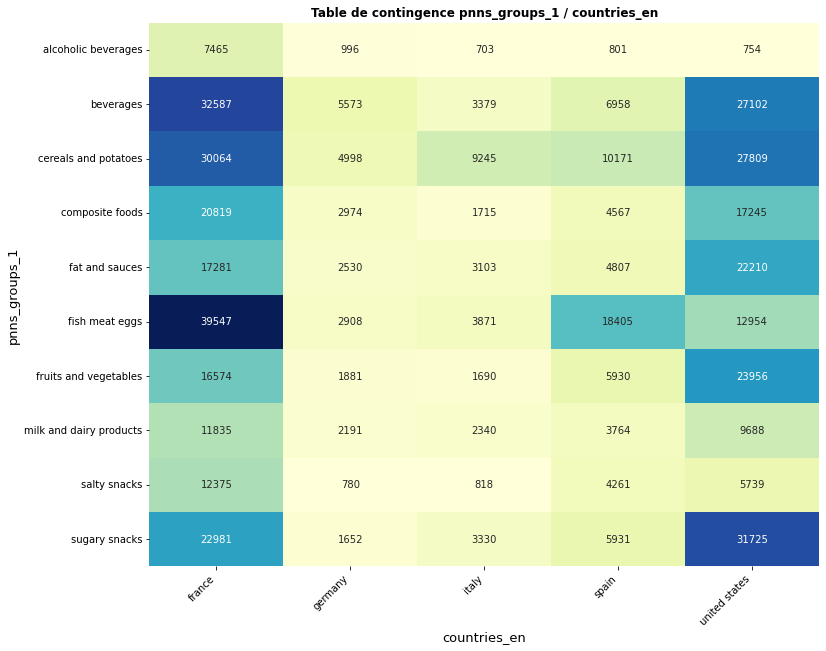

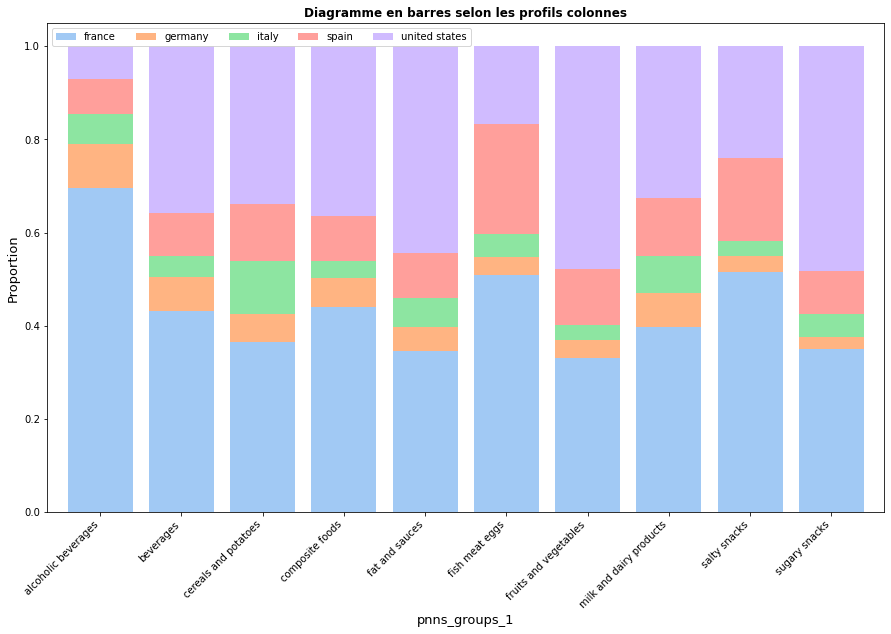

Chaque effectif de la table de contingence >= 5 => Test du Chi2 applicable
-------------------------------------------------------------------
Chi2: 44087.84879079478
Degrees of freedom: 36
-------------------------------------------------------------------
pvalue: 0.0 < 0.05 => on rejette H0, les variables sont dépendantes


In [77]:
chi2_test(data_TOP5_country, 'pnns_groups_1', 'countries_en')

##### pnns_groups_2

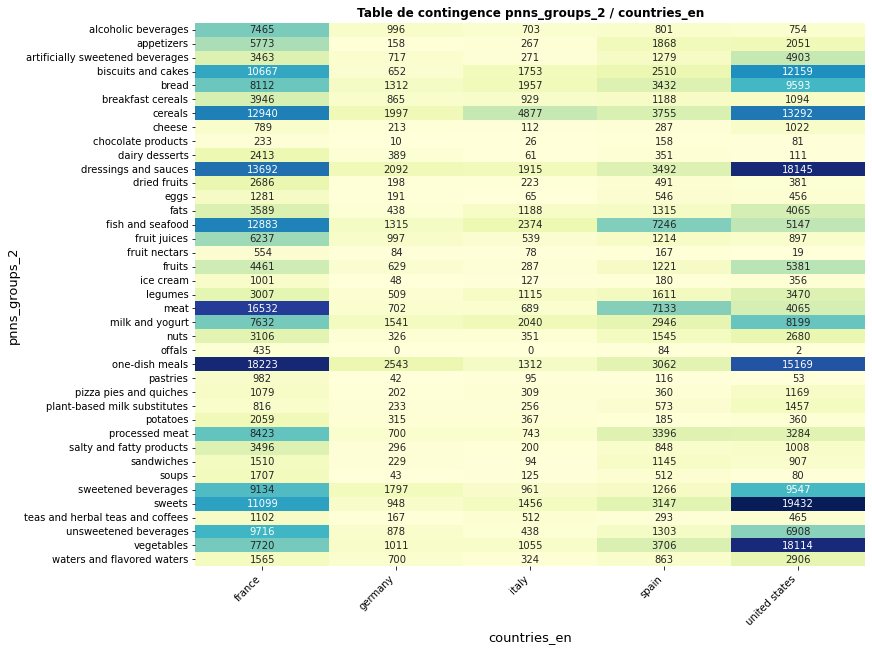

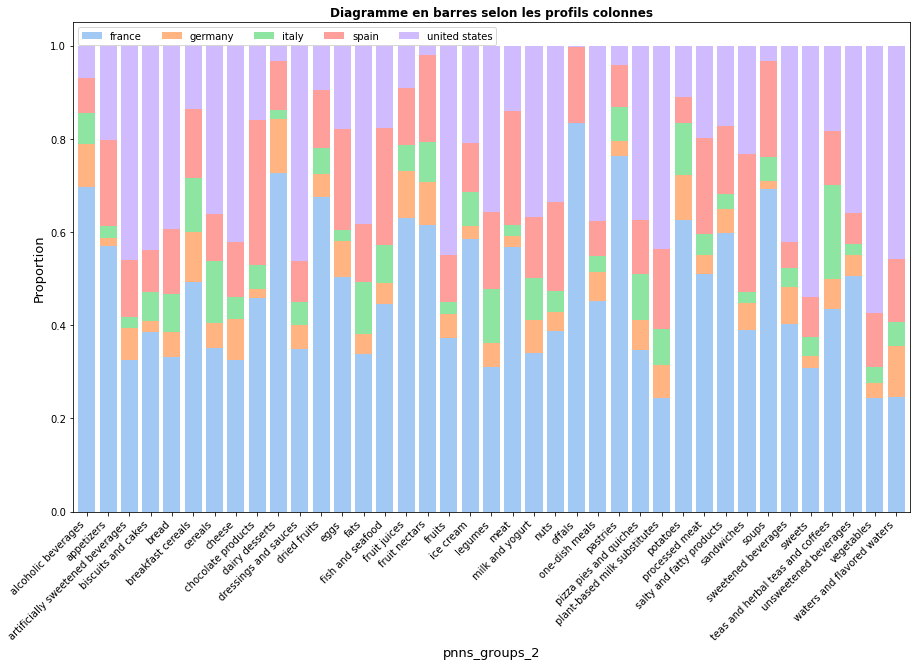

Au moins un effectif de la table de contingence < 5 => Test du Chi2  non applicable


In [78]:
chi2_test(data_TOP5_country, 'pnns_groups_2', 'countries_en')

#### nova_group vs nutriscore_grade

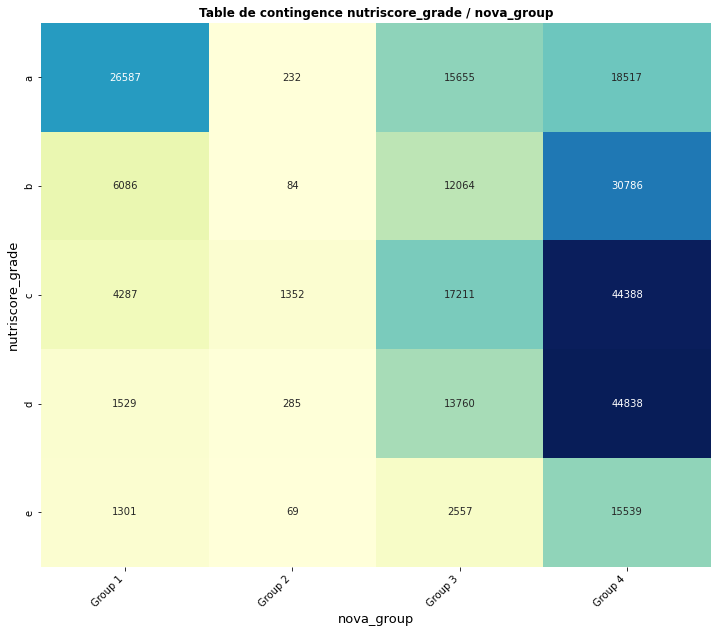

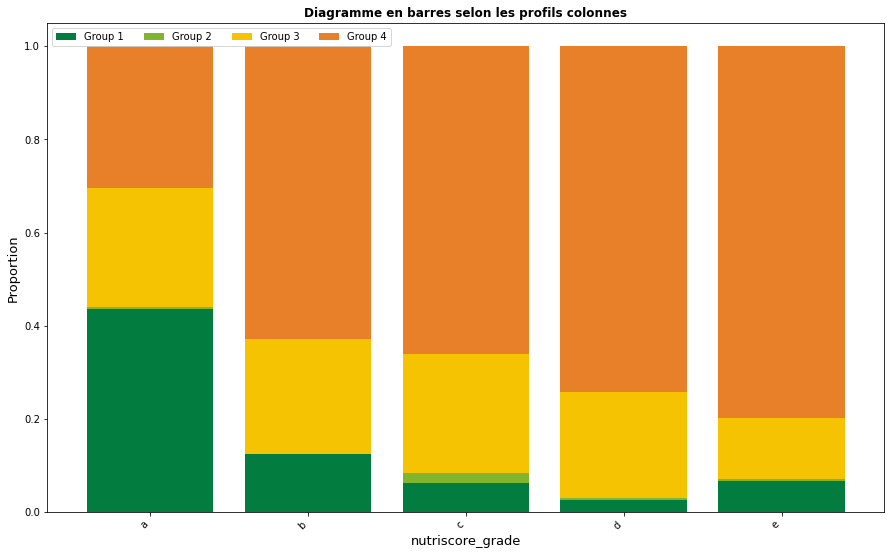

Chaque effectif de la table de contingence >= 5 => Test du Chi2 applicable
-------------------------------------------------------------------
Chi2: 58210.843359687664
Degrees of freedom: 12
-------------------------------------------------------------------
pvalue: 0.0 < 0.05 => on rejette H0, les variables sont dépendantes


In [79]:
data_nutri_nova = data[(data['nutriscore_grade'] != 'unknown') & (data['nova_group'] != 'unknown')]
my_colors = ['#037d3f', '#81b52e', '#f5c301', '#e78029',   '#df3c10', '#e5e0e0']
chi2_test(data_nutri_nova, 'nutriscore_grade', 'nova_group', palette = my_colors)

<div class="alert alert-block alert-info">
    <p> Comment gérer la taille du tableau des fréquences? Le remonter? </p>
    <p> OK moyenne etc pour var discrètes? </p>
    <p> Outliers additives à traiter </p>
</div>

In [ ]:
#### Analyse en Composantes Principales

In [ ]:
openfoodfacts_nan.columns[openfoodfacts_nan.columns.str.endswith('100g')]

In [ ]:
# Sélection des colonnes à prendre en compte dans l'ACP et remplissage des NaN par la moyenne
liste_col_pca = ['energy_kj_100g', 'fat_100g', 'saturated-fat_100g',
       'monounsaturated-fat_100g', 'polyunsaturated-fat_100g',
       'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'alcohol_100g', 'vitamin-a_100g', 'vitamin-c_100g',
       'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g',
       'potassium_100g', 'calcium_100g', 'iron_100g',
       'fruits-vegetables-nuts-estimate-from-ingredients_100g']
data_pca = openfoodfacts_nan[liste_col_pca]
X = data_pca.fillna(data_pca.mean()) # fréquent de remplacer les NaN par la moyenne

In [ ]:
# Préparation des données pour l'ACP
keep_ind = X.index
X = StandardScaler().fit_transform(X)

In [ ]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=4)
pca.fit(X)
X = pca.transform(X)

In [ ]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [ ]:
display_scree_plot(pca)

In [ ]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(15,15))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [ ]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, 4, pca, [(0,1), (2,3)], labels = np.array(liste_col_pca))